## Diffusion equation solution

In [1]:
%reset -f
import numpy as np
from LebedevHelper import *

import matplotlib.pyplot as plt
import scipy as sc
import scipy.stats as st
import scipy.special as spec
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import scipy.integrate as integrate
import pickle as pkl
import multiprocessing as mp

%matplotlib notebook



In [2]:
# Set style of plots
ticksize= 16
titlesize = 18
# mpl.style.use('classic')
mpl.rcParams.update({'font.size':ticksize }) 
mpl.rcParams.update({'legend.fontsize':ticksize })# legend
mpl.rcParams.update({'ytick.labelsize':ticksize-2 })
mpl.rcParams.update({'xtick.labelsize':ticksize-2 })
mpl.rcParams.update({'axes.titlesize':titlesize})       # Title
mpl.rcParams.update({'axes.labelsize':titlesize})    # x,y,cbar labels
mpl.rcParams.update({'figure.titlesize' :titlesize})
mpl.rcParams.update({'savefig.bbox':'tight'})
mpl.rcParams.update({'axes.formatter.limits':[-3,3]})
mpl.rcParams.update({'figure.figsize':[6,4]})
mpl.rcParams.update({'mathtext.fontset':'cm'})
mpl.rcParams.update({'font.style':'normal'})
mpl.rcParams.update({'image.cmap':'rainbow'})
mpl.rcParams.update({'axes.formatter.useoffset':False})   # no offset of axis
mpl.rcParams.update({'axes.formatter.use_mathtext':True}) # Change from 1e4 to 10^4 

# To use unicode
mpl.rc('font', **{'sans-serif' : 'Arial','family' : 'sans-serif'})
# To get sans-serif
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)


np.set_printoptions(precision=3,suppress=True) 
plt.close('all')

# 1D Secure

In [3]:
# xx = [0,1,2,3,4]+[np.inf]
# xc =[0]+[.5,1.5,2.5,3.5] +[4.5,np.inf]

# psic = [.6,.4,.22,.1] + [0]
# dpsi = np.diff(psic)
# dpsi = np.array([dpsi[0]] + list(dpsi)+[0])
# print('xx',xx)
# print(psic)
# print('xc',xc)
# print(dpsi)

# print(next(i for i,v in enumerate(xx) if v > 0)-1)
# print(next(i for i,v in enumerate(xc) if v > 1)-1)
# # print(np.where(xa==4))

In [7]:
# PySSD
import seaborn as sns
import sys,time
sys.path.append('../')
from PySSD.Distribution import Distribution,Gaussian
from PySSD.Detuning import LinearDetuning
from PySSD.Dispersion import Dispersion
from PySSD.Integrator import FixedTrapezoidalIntegrator, SimpsonIntegrator, TrapzIntegrator, DblquadIntegrator

def findQs(detuning, stepSize=5E-5, maxJ=18.0, dJ=0.1, margin=1):
    '''
    '''
    myMin = 1.0
    myMax = 0.0
    for jx in np.arange(0, maxJ, dJ):
        for jy in np.arange(0, maxJ, dJ):
            value = detuning(jx, jy)
            if value < myMin :
                myMin = value
            if value > myMax :
                myMax = value
    return np.arange(myMin-margin*stepSize, myMax+margin*stepSize, stepSize)

def get_tune_range(detuning, maxJ=18.0, margin=1e-4, n_samples=100):
    myMin = 1.0
    myMax = 0.0
    for jx in np.linspace(0, maxJ, 100):
        for jy in np.linspace(0, maxJ, 100):
            value = detuning(jx, jy)
            if value < myMin :
                myMin = value
            if value > myMax :
                myMax = value
    return np.linspace(myMin - margin, myMax + margin, n_samples)

class MyDistribution1D(Distribution):
    def __init__(self,Jb=0,Jc=0,Psic=0,dPsi=0):
        self._Jb=Jb.tolist() 
        self._Psic=Psic.tolist() +[0]
        Jc[0]=0 # let first derivative cell start at zero
        self._Jc=Jc.tolist()
        self._dPsi=dPsi.tolist() +[0]
    
    
    def getValue(self, jx, jy):
        func = sc.interpolate.interp1d(self._Jb,self._Psic,kind='previous')
        return func(jx)*np.exp(-jy)

    def getDJx(self, jx, jy):
        func = sc.interpolate.interp1d(self._Jc,self._dPsi,kind='previous')
        return func(jx)*np.exp(-jy)

    def getDJy(self, jx, jy):
        return -self.getValue(jx, jy)
    
class MyDistribution1Dy(Distribution):
    def __init__(self,Jb=0,Jc=0,Psic=0,dPsi=0):
        self._Jb=Jb.tolist() 
        self._Psic=Psic.tolist() +[0]
        Jc[0]=0 # let first derivative cell start at zero
        self._Jc=Jc.tolist()
        self._dPsi=dPsi.tolist() +[0]
    
    
    def getValue(self, jx, jy):
        func = sc.interpolate.interp1d(self._Jb,self._Psic,kind=['previous','next'][0])
        return func(jy)*np.exp(-jx)

    def getDJx(self, jx, jy):
        return -self.getValue(jx, jy)
    
    def getDJy(self, jx, jy):
        func = sc.interpolate.interp1d(self._Jc,self._dPsi,kind=['previous','next'][0])
        return func(jy)*np.exp(-jx)
    
    
class MyDistribution2D(Distribution):
    #TODO
    def __init__(self,Jb=0,Jc=0,Psic=0,dPsi=0):
        self._Jbx=Jb.tolist() 
        self._Psic=Psic.tolist() +[0]
        Jc[0]=0 # let first derivative cell start at zero
        self._Jcx=Jc.tolist()
        self._dPsi=dPsi.tolist() +[0]


In [40]:
# Define functions
def DiffCoeff(x,g2,dmu,Dnr,Deq,Dibs=0):
    # Return diffusion coefficient - including r or J
    # JD or rD/2
    DD = np.ones_like(dmu)
    if Dnr==1:
        DD[:] = Deq  
    elif Dnr==2:
        DD[:] = Deq * LL(g2,dmu)  
        
    return ( DD  + Dibs ) * (x)

def DriftCoeff(x,J,bool_radial,g2,dmu,dDmudJ,Dnr,Deq):
    # Return velocity , i.e. need negative of what is proportional to 
    # J*dD/dJ  or r**2*d(D/2)/dJ    
    dDDdJ = np.zeros_like(dmu)
    if Dnr==1:
        None
    elif Dnr==2:
        dDDdJ = Deq * dLLdm(g2,dmu) * dDmudJ *J*[1,2][bool_radial]  #dLLdm from LebedevHelper.py
        
    return dDDdJ 


# Numerical integration
def trapezoidal(x,y,bool_FVM=0):
    if bool_FVM:
        dx = np.diff(x)[0]
        return np.sum(np.diff(x)*y)
    else:
        return np.sum(np.diff(x)*(y[1:]+y[:-1]))*0.5

########################   
## Plotting functions ##
def func_moments(xb,xc,psis,ts,bool_radial,bool_FVM):
    # store moments
    moments = np.zeros((ts.size,4))
    for i , t in enumerate(ts):
        if bool_radial:
            moments[i,:] = [trapezoidal(xb,xc*psis[i,:]*xc**j ,bool_FVM) for j in [0,1,2,3]]
        else:
            moments[i,:] = [trapezoidal(xb,   psis[i,:]*xc**j ,bool_FVM) for j in [0,1,2,3]]
    return moments

def plot_psis_r(x,psis,ts,bool_radial,D,sig0=1,plot_sep=1,bool_theory_g0=1,xmax=6,lw=1,ls='-',
                fignradd=0,bool_fill=0):
    # Set colorbar as time measurement:
    norm = mpl.colors.Normalize(vmin=ts.min()/time_scale, vmax=ts.max()/time_scale)
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
    cmap.set_array([])

    fig1, ax1 = plt.subplots(num=30+2*bool_radial+fignradd)
    fig2, ax2 = plt.subplots(num=31+2*bool_radial+fignradd)
    
    for i , t in enumerate(ts):  
        if i%plot_sep==0:
            if not bool_fill:
                ax1.plot(x, psis[i,:], c=cmap.to_rgba(t/time_scale),lw=lw,ls=ls)
            else:
                if t==ts[-1]: continue
                ax1.fill_between(x, psis[i,:],psis[i+1,:], color=cmap.to_rgba(t/time_scale))
            ax2.plot(x,(psis[i,:]-psis[0,:])/psis[0,:], c=cmap.to_rgba(t/time_scale),lw=lw,ls=ls)

    # Theoretical curve
    if bool_theory_g0:
        tmax = np.max(ts)
        sig2t = sig0**2 + 2*D*tmax
        if bool_radial:
            psitheory = 1/sig2t*np.exp(-0.5*x**2/sig2t)
        else:
            psitheory = 1/sig2t*np.exp(-x/sig2t)
        ax1.plot(x,psitheory,'--k',lw=4,dashes=[1,5],dash_capstyle='round',label=r'Theory, $g=0$')
    
    # Fix layout of plots
    for ax in [ax1,ax2]:
        ax.legend(loc=0)
        ax.set_xlabel([r'$J$',r'$r$'][bool_radial],labelpad=[-1,-5][bool_radial])
        ax.set_xlim([0,[.5*xmax**2,xmax][bool_radial]])
        ax.grid(True)
    ax1.set_ylabel(r'$\Psi$')
    if not bool_radial:  ax1.set_yscale('log')
    ax2.set_ylabel(r'$\Psi(t)-\Psi(0)$')
    ax2.set_ylim([-1,1])
    
    for fig in [fig1,fig2]:
        cb=fig.colorbar(cmap,label=tlabel) #ticks = np.linspace(0,tmax/time_scale,4),
        tick_locator = mpl.ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        fig.tight_layout()

    return fig1,ax1,fig2,ax2

In [111]:
class MachineClass(object):
    def __init__(self,detuning,g=0):
        self.detuning = detuning
        self.g = g
        
from abc import ABCMeta, abstractmethod
class Detuning(object):
    @abstractmethod
    def __init__(self,*args):
        pass
    def Qx(Jx,Jy):
        pass
    def Qy(Jx,Jy):
        pass
    def dQxdJx(Jx,Jy):
        pass
    def dQxdJy(Jx,Jy):
        pass
    def dQydJx(Jx,Jy):
        pass
    def dQydJy(Jx,Jy):
        pass
class LinearDetuning(Detuning):
    def __init__(self,Q0x,Q0y,a,b):
        self.Q0x = Q0x
        self.Q0y = Q0y
        self.ax = a
        self.bx = b
        self.ay = a
        self.by = b
    def Qx(Jx,Jy):
        return self.Q0x + self.ax*Jx + self.bx*Jy
    def Qy(Jx,Jy):
        return self.Q0x + self.ay*Jy + self.by*Jx
    def dQxdJx(Jx,Jy):
        return self.ax
    def dQxdJy(Jx,Jy):
        return self.bx
    def dQydJx(Jx,Jy):
        return self.by
    def dQydJy(Jx,Jy):
        return self.ay
    
detuning = LinearDetuning(0.31,0.32,a,b)
mach = MachineClass(detuning,3)
detuning.

0.005

In [75]:
# Calculation parameters
alpha= 1              # alpha = 0: direct from Lebedev, alpha=1: cancel drift term
Dnr  = 2              # Which diffusion coefficient [0, constant (r), K*LL (r),...,10,constant (J),K*LL(J)]
bool_FVM = 1          # true: use FVM, false: use FDM  (only implemented FVM)
bool_radial = 0       # true: radial PDE, false: action PDE
bool_adjustGrid = 1   # true: shift grid so that one cell is centered on the zero
bool_BC_xmax = 0      # i = [Dirichlet Psi=0, Neumann djPsi=0, Robin: djPsi+Psi=0 or drPsi+rPsi=0, dPsi const]
bool_savefig = 1

# Time parameters
f_LHC = 11.245e3
# nturns = f_LHC * 3600 * 24
nturns = 3e6*1e4 
nturns = [37.5e6,100e6][alpha]     # 100e6 for comparison to COMBIp, 37.5 for comparison to easy incoherent noise
tmax = nturns/f_LHC
# nt=int(nturns/5e5)+1
nt = 81
# nt = 4
tsODE = np.linspace(0,tmax,nt)


# Beam and Machine parameters
a=5e-3  
b=0
g=0.2

# Noise parameters
sigma_k = 1e-4
sigma_k = 1e-3 /np.sqrt(3) 
JAvg = 1
D0  = sigma_k**2*f_LHC / (2 + 2*bool_radial) # need a second '/2' if operating with r
sigma_ibs= 0
Dibs= sigma_ibs**2*f_LHC / (2 + 2*bool_radial) # need a second '/2' if operating with r

#temp for harmonic excitation
An     = 0  # Harmonic excitation noise
Jn     = 1
# Dmax
# wJ


# Define grid 
Nc = 810
Nb = Nc+1
rMax = 7         ; rAvg = np.sqrt(2*JAvg) 
JMax = rMax**2/2 ; JAvg = JAvg              #See noise parameters

In [80]:
####################
## Calculate grid ##
if bool_radial:     
    h = rMax/Nc
    if bool_adjustGrid:
        h = (rAvg)/np.floor(rAvg/h)   # adjust so that boundary is at rAvg
#         h = (rAvg)/(np.floor(rAvg/h-.5)+.5)
        print('Change of h from %.3f to %.3f - rMax from %.3f to %.3f'%(6/Nc,h,rMax,h*Nc))
    rb = np.arange(Nb)*h
    rc = edges_to_center(rb)
    Jc = .5*rc**2
    Jb = .5*rb**2
    
    # temporary
#     Jc = edges_to_center(Jb)
else:
    # not yet implemented action version
    h = JMax/Nc
    Jb = np.linspace(0,JMax,Nb)
    Jc = edges_to_center(Jb)
    rb = np.sqrt(2*Jb)
    rc = edges_to_center(rb)
#     print('ERROR - J not implemented 1')

############################################
## Define matrices required for iteration ##
if bool_radial:
    MmeanR = (np.eye(Nc,k=0) + np.eye(Nc,k=1) )/(2*h*rc[:,np.newaxis])
    MmeanL = (np.eye(Nc,k=0) + np.eye(Nc,k=-1))/(2*h*rc[:,np.newaxis])
    MdiffR =(-np.eye(Nc,k=0) + np.eye(Nc,k=1) )/(h*h*rc[:,np.newaxis])
    MdiffL = (np.eye(Nc,k=0) - np.eye(Nc,k=-1))/(h*h*rc[:,np.newaxis])
else:
    # not yet implemented action version
#     print('ERROR - J not implemented 2')
    MmeanR = (np.eye(Nc,k=0) + np.eye(Nc,k=1) )/(2*h)
    MmeanL = (np.eye(Nc,k=0) + np.eye(Nc,k=-1))/(2*h)
    MdiffR =(-np.eye(Nc,k=0) + np.eye(Nc,k=1) )/(h*h)
    MdiffL = (np.eye(Nc,k=0) - np.eye(Nc,k=-1))/(h*h)
    
# Reflective boundary at r=0
MdiffL[0,0]=0
MmeanL[0,0]=0

# BC at xmax
if bool_BC_xmax==0:
    # Absorbing Dirichlet Psi=0
    None
elif bool_BC_xmax==1:
    # Reflective boundary at r=rMax
    MdiffR[-1,-1]=0
    MmeanR[-1,-1]*=2
elif bool_BC_xmax==2:
    # Robin condition, not yet perfect
    if bool_radial:
        MdiffR[-1,-1]*=   h*rc[-1]
        MmeanR[-1,-1]*=(2-h*rc[-1])
    else:
        MdiffR[-1,-1]*=   h
        MmeanR[-1,-1]*=(2-h)
elif bool_BC_xmax==3:
    # dJPsi_N = dJPsi_N+1
    MdiffR[-1,-2]=MdiffR[-1,-1]
    MdiffR[-1,-1]*=(-1)
    MmeanR[-1,-2] =-MmeanR[-1,-1]
    MmeanR[-1,-1]*=3

if Nc <11:
    print(rb)
    print(rc)
    
    print(MmeanR)
    print(MmeanL)
    print(MdiffR)
    print(MdiffL)

# Calculate coefficients 
g2  = func_g2(g)
dmu = func_dmu(a,Jb,Javg=JAvg) 
dDmudJ = pi2*a                 # <- TODO: Make this more general (if need be)

# Get expression for D and dD/dJ
Diff  = DiffCoeff( [Jb,rb][bool_radial],g2,dmu,Dnr,D0,Dibs)[:,np.newaxis]
Drift = DriftCoeff([Jb,rb][bool_radial],Jb,bool_radial,g2,dmu,dDmudJ,Dnr,D0)[:,np.newaxis]


FV_M = (MdiffR*Diff[1:] - MdiffL*Diff[:-1]) + (1-alpha)*(MmeanR*Drift[1:] - MmeanL*Drift[:-1])

###########################
## Solve PDE numerically ##
sig0 = 1
psi0 = 1/sig0*np.exp(-rc**2/(2*sig0**2))

def dpsidtFV(t,psi,r,A=FV_M):
    return A.dot(psi)

dtmax = h**2/(2*D0)
print('Chosen dt for ODE output: %.3f \n'%(np.diff(tsODE)[0])+
      'From Neumann analysis - dt<%.2e - need a bit more margin at large r (if use Explicit method)'%(dtmax))
# psis = sc.integrate.odeint(dpsidtFV,psi0,tsODE,args=(rc,),hmax=dtmax*1,tfirst=True)

dpsidtFV_ivp=lambda t, y: dpsidtFV(t, y, rc)
solution = sc.integrate.solve_ivp(dpsidtFV_ivp, t_span=[0,tmax],y0=psi0,t_eval=tsODE,
#                                   method='RK45',max_step=dtmax)
                                  method='BDF')
tsODE= solution.t
psis = solution.y.T
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
psis1D=psis

# Get distribution in J as well
if bool_radial:
    psisR = psis
    psisJ = psis[:]*rc*np.diff(rb)/np.diff(Jb)
else:
    psisJ = psis
    psisR = psis[:]*np.diff(Jb)/(rc*np.diff(rb))
dPsis = np.diff(psisJ[:])/np.diff(Jc)

Chosen dt for ODE output: 111.161 
From Neumann analysis - dt<2.44e-01 - need a bit more margin at large r (if use Explicit method)


nt=81 , nplots=100 -> plot_sep=1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


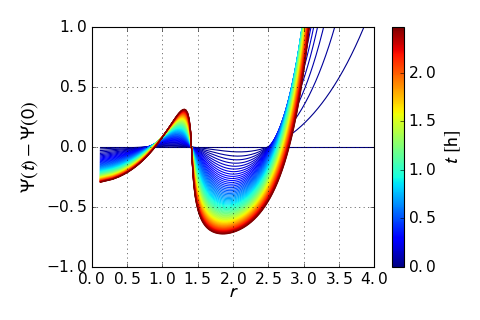

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [81]:
# Plotting
time_scale = 1 ;  tlabel=r'$t$ $[\mathrm{sec}]$'
time_scale = 60 ; tlabel=r'$t$ $[\mathrm{min}]$'
time_scale = 3600 ; tlabel=r'$t$ $[\mathrm{h}]$'

# nplots: number of curves from psis
psis=psis1D
nplots=100
plot_sep = int(np.ceil(np.size(tsODE)/nplots))
print('nt=%d , nplots=%d -> plot_sep=%d'%(nt,nplots,plot_sep))

    

#######################
## Plot distribution ##
fig1,ax1,fig2,ax2 = plot_psis_r(rc,psisR,tsODE,bool_radial or True,D0+Dibs,sig0,plot_sep,
                                bool_theory_g0=(g==0),xmax=4,lw=1,ls='-',bool_fill=0)
ax1.grid(True)

if bool_savefig:
    fig1.savefig('03_Plots/DDIST_a%.0e_b%.0e_g%.0e_D^2*Nt%.0e.eps'%(
                a,b,g,sigma_k**2*nturns))

#Plot incoherent noise curves on top
if 0:
    import matplotlib.lines as mlines
    dir_save = '01_Output'
    with open(dir_save+'/incoherentNoise_a%.0e_b%.0e_g%.0e_D^2*Nt%.0e_Np%.0e_Nstep%d.pkl'%(
        a,b,g,sigma_k**2*nturns,1e6,nt),'rb') as pklfile:
        print(pklfile.name)
        storage = pkl.load(pklfile)
    for line in ax1.lines:
#         line.set_ls('-')
        line.set_dashes([3,7])
        line.set_lw(4)
    for i in range(storage['params']['nt']):

        ax1.plot(storage['rcenter'],storage['dist_rs'][i], c=cm.jet(i/(nt-1)),ls='-',lw=1.)
    ax1.set_xlim(0,4)
    ax1.set_ylim(0,1.05)
    dots =  mlines.Line2D([],[],c='k',lw=4,dashes=[3,7],label='Fokker-Planck')
    line =  mlines.Line2D([],[],c='k',ls='-',label='Simulation')
    ax1.legend(handles=[dots,line],frameon=True,borderaxespad=0,borderpad=.4,handletextpad=0,fontsize=14)
    fig1.savefig('03_Plots/DDIST_a%.0e_b%.0e_g%.0e_D^2*Nt%.0e_compToIncoNoise.eps'%(
        a,b,g,sigma_k**2*nturns))


<IPython.core.display.Javascript object>


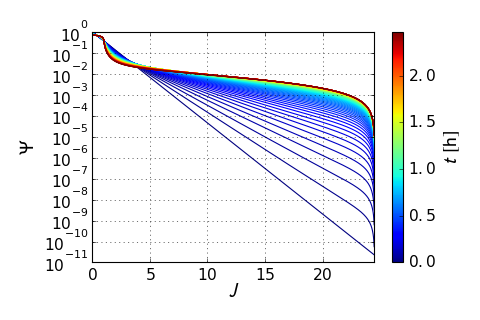

<IPython.core.display.Javascript object>


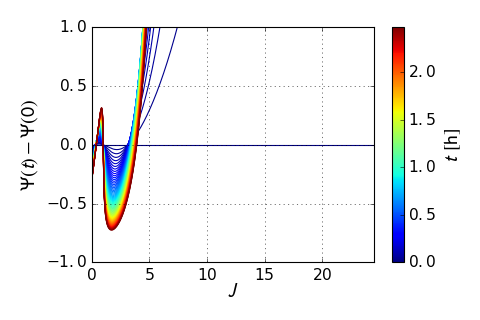

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


<IPython.core.display.Javascript object>


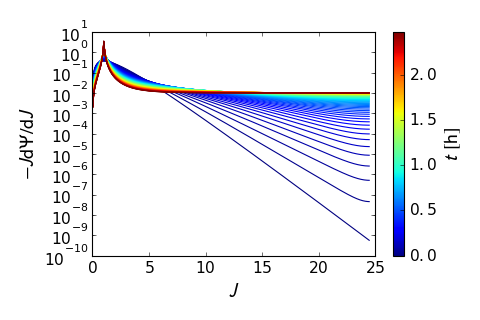

<IPython.core.display.Javascript object>


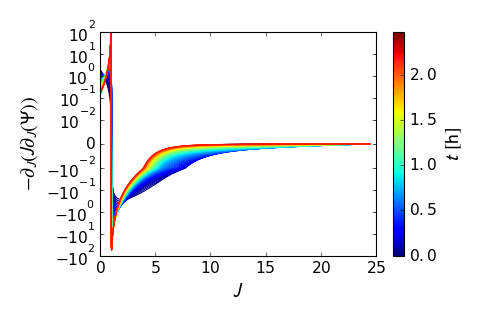

<IPython.core.display.Javascript object>


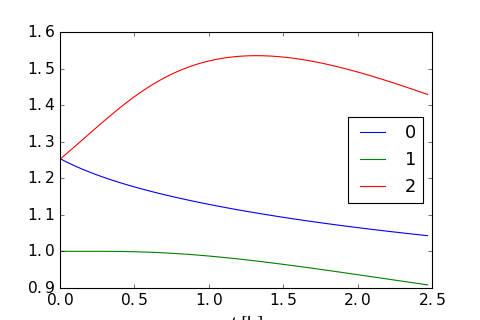

<IPython.core.display.Javascript object>


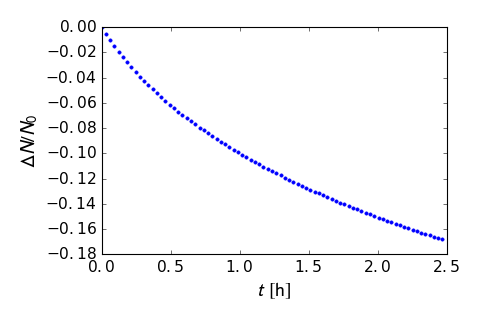

<IPython.core.display.Javascript object>


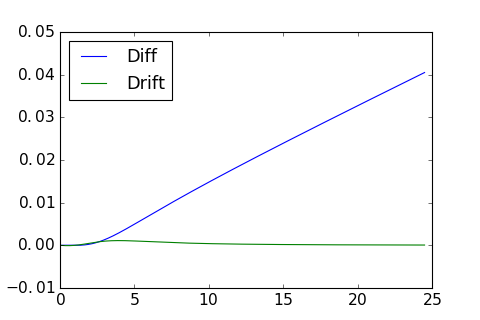

In [82]:
# if bool_radial :
#     psisJ = psis[:]*rc*h/np.diff(Jb)
plot_psis_r(Jc,psisJ,tsODE,0,D0+Dibs,sig0,plot_sep,
            bool_theory_g0=(g==0),xmax=rMax)
    

        
#####################################
## Plot derivative of distribution ##
bool_jdPsidj = 1

fig = plt.figure()
norm = mpl.colors.Normalize(vmin=tsODE.min()/time_scale, vmax=tsODE.max()/time_scale)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])
for i,t in enumerate(tsODE):
    plt.semilogy(Jb[1:-1],-[1,Jb[1:-1]][bool_jdPsidj]*dPsis[i],c=cmap.to_rgba(t/time_scale))
cb=fig.colorbar(cmap,label=tlabel) #ticks = np.linspace(0,tmax/time_scale,4),
tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
fig.tight_layout()
plt.xlabel(r'$J$')
plt.ylabel(r'$-%s\mathrm{d}\Psi/\mathrm{d}J$'%['','J'][bool_jdPsidj])
plt.tight_layout()
    
#####################################
## Plot double derivative of distribution ##
fig = plt.figure()
norm = mpl.colors.Normalize(vmin=tsODE.min()/time_scale, vmax=tsODE.max()/time_scale)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])
for i,t in enumerate(tsODE[:72]):
    f = -[1,Jb[1:-1]][bool_jdPsidj]*dPsis[i]
    f1= np.diff(f)/np.diff(Jb[1:-1])
    f3= np.zeros_like(f1)
    f3[1:-1] = (f1[2:]-f1[1:-1]+f1[:-2])/np.diff(Jb[2:-2])**2
    plt.plot(Jc[1:-1],2*f1+0*f3,c=cmap.to_rgba(t/time_scale))
plt.yscale('symlog', linthreshy=1e-2)
cb=fig.colorbar(cmap,label=tlabel) #ticks = np.linspace(0,tmax/time_scale,4),
tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
fig.tight_layout()
plt.xlabel(r'$J$')
plt.ylabel(r'$-\partial_J(%s\partial_J(\Psi))$'%['','J'][bool_jdPsidj])
plt.tight_layout()
    
##################
## Plot moments ##
moments = func_moments(rb,rc,psis,tsODE,bool_radial,bool_FVM)
plt.figure(num=15)
for i in range(3):
    plt.plot(tsODE/time_scale,moments[:,i],label=str(i))
plt.xlabel(tlabel)
plt.legend(loc=0)


##############################
## Plot intensity evolution ##
plt.figure(num=16)
plt.plot(tsODE/time_scale,(moments[:,0]-moments[0,0])/moments[0,0],'.')
plt.ylabel(r'$\Delta N/N_0$')
plt.xlabel(tlabel)
plt.tight_layout()
plt.legend(loc=0)


######################################
## Plot diff and drift coefficients ##
if 1:
    plt.figure(num=17)
    plt.plot([Jb,rb][bool_radial],Diff[:,0],label='Diff')
    plt.plot([Jb,rb][bool_radial],Drift[:,0],label='Drift')
    plt.legend(loc=0)

# Stability diagrams

In [83]:
# Testing numbers of different detuning coefficients

print(0.82*4/6.5 *1000/0.938)
print(-0.58*4/6.5*1000/0.938)

260*0.938/1000
# 0.82 * 4/6.5 * 

# How to calculate a and b from Nicolas
# https://infoscience.epfl.ch/record/174672/files/EPFL_TH5305.pdf
# /afs/cern.ch/work/l/lhcim/public/IRIS/LHC_IW_model/Python-scripts
IoctF = 1
IoctD = -IoctF
E_gev = 6500
ax =7000/E_gev * (267065/550 * IoctF - 7856  /550*IoctD)
ay =7000/E_gev * (9789  /550 * IoctF - 277203/550*IoctD)
bb  =7000/E_gev *(-102261/550 * IoctF + 93331 /550*IoctD)
print(ax,ay,b)

537.9694931933738
-380.51500738067904
538.3068531468531 561.9423776223775 0


In [354]:
# Calculate stability diagrams    
energy = 6.5
emittance = 2e-6
gamma = energy / 0.938e-3
beta = np.sqrt(1- 1/gamma**2)
emittance_g=emittance/(beta*gamma)
i_octupoles = 400
# i_octupoles = np.arange(-500, 0, 50)
a_x =  0.82*4 * i_octupoles*emittance/energy**2
a_y = -0.58*4 * i_octupoles*emittance/energy**2

# Result from own paper
a_x = 520*i_octupoles*emittance_g
a_y =-380*i_octupoles*emittance_g 
integrator_epsilon = 2e-7


# a_x = a
# a_y = b
a_y = 0 ; integrator_epsilon = 1e-6

print('a_x=%.3e \na_y=%.3e'%(a_x,a_y))
print(a_x/emittance_g,a_y/emittance_g)
print(integrator_epsilon)


# a_x=1.72e-07 *100
# a_y=-1.15e-07*100



    
    

def collect_result(res):
    results.append(res)
    
def calc_Stability_Diagram(args):
    # Take input
    [i,plane, psi,dPsi,a_x,a_y,nQ] =args
    
    #Set distribution
    if   plane < 0: distribution = Gaussian()
    elif plane ==0: distribution = MyDistribution1D( Jb,Jc, psi,dPsi)
    else:           distribution = MyDistribution1Dy(Jb,Jc, psi,dPsi)

    detuning = LinearDetuning(.31, a_x, a_y)
    
    #Instead take stability in other plane
    if plane ==1:
        distribution = MyDistribution1Dy( Jb,Jc, psi,dPsi) # need dispersion(Jy*dPsi/dJ)
        detuning = LinearDetuning(.32, a_x, a_y)
    
#     integrator = SimpsonIntegrator(distribution, detuning, maxJ=18)
    integrator = TrapzIntegrator(distribution, detuning, maxJ=18)
#     integrator = DblquadIntegrator(distribution, detuning, maxJ=18)

    t0 = time.clock()
#         tunes = get_tune_range(detuning)
    tunes = get_tune_range(detuning,margin=1e-4, n_samples=nQ)
    tune_shifts = np.zeros((len(tunes)), dtype='complex')
    for k, q in enumerate(tunes):
        tune_shifts[k] = integrator.integrate(q,epsilon=integrator_epsilon)
    
#     Norm = trapezoidal(Jb,psi,1)
#     Norm = 1
    
    # Timing
    t1 = time.clock()-t0
    print("Elapsed times (%d,%s): %.2fs."%(i,['x','y'][plane],t1))
    return (i,tune_shifts,tunes)
        
    
    
tune_shifts_calculated = np.zeros_like(tsODE)
indexSD = np.arange(0,nt,2)
tsSD = tsODE[indexSD]
ntSD = np.size(indexSD)
nQ = 100
print(indexSD)
for plane in [0,1]:
#     continue
    
    if plane==0  : 
        tune_shifts_all1 = np.zeros((ntSD,nQ),dtype='complex')
        tunes_Q_all1     = np.zeros((ntSD,nQ))
    elif plane==1: 
        tune_shifts_all2 = np.zeros((ntSD,nQ),dtype='complex')
        tunes_Q_all2     = np.zeros((ntSD,nQ))
    else:
        continue
    
    #Paralellisation preperation
    nProcs = min(np.size(indexSD),mp.cpu_count()-1)
    print("%d processes"%nProcs)
    pool = mp.Pool(processes = nProcs)
    procs = []
    results = []
    
    for ind,i in enumerate(indexSD):
        t = tsODE[i]
        # Parallellisation
        args = [ind,plane,psisJ[i],dPsis[i],a_x,a_y,nQ]
        p = pool.apply_async(calc_Stability_Diagram, args = (args,),callback = collect_result)
        procs.append(p)
    
    ###################
    # Join forces again
    pool.close()
    pool.join()
    
    for j,_ in enumerate(indexSD):
#         print(results[j])
        print(i,j)
        i,res,res2 = results[j]
        if plane==0: 
            tune_shifts_all1[i]= res
            tunes_Q_all1[i] = res2
        else:
            tune_shifts_all2[i]= res
            tunes_Q_all2[i] = res2
        tune_shifts_calculated[i]=1
        

if 1:
    args = [-1,-1,np.arange(2),np.arange(2),a_x/2,a_y/2,nQ]
    tune_shifts_halfI = calc_Stability_Diagram(args)[1]


a_x=6.003e-05 
a_y=0.000e+00
208000.0 0.0
1e-06
[0 2 4 6 8]
5 processes
Elapsed times (1,x): 16.87s.
Elapsed times (4,x): 16.97s.
Elapsed times (3,x): 17.21s.
Elapsed times (0,x): 17.08s.
Elapsed times (2,x): 17.34s.
8 0
1 1
4 2
3 3
0 4
5 processes
Elapsed times (3,y): 17.08s.
Elapsed times (2,y): 17.38s.
Elapsed times (0,y): 17.75s.
Elapsed times (4,y): 18.13s.
Elapsed times (1,y): 18.34s.
8 0
3 1
2 2
0 3
4 4
Elapsed times (-1,y): 7.96s.


<IPython.core.display.Javascript object>


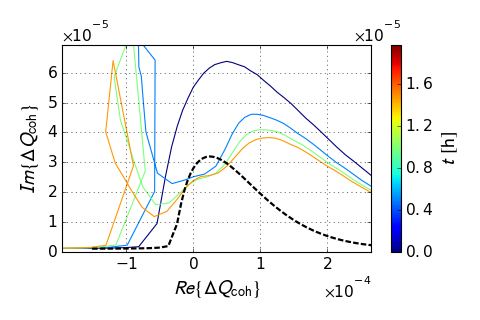

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


<IPython.core.display.Javascript object>


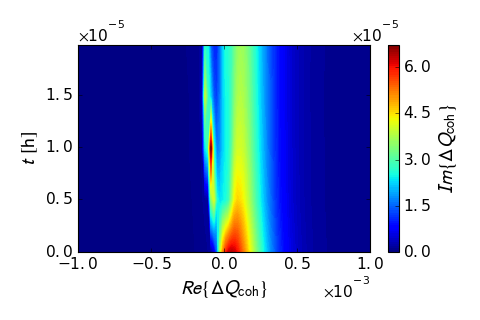

False [ 0.     0.68   1.36   2.039  2.719  3.399  4.079  4.759  5.439  6.118
  6.798  7.478  8.158  8.838  9.517 10.197 10.877 11.557 12.237 12.916
 13.596 14.276 14.956 15.636 16.316 16.995 17.675 18.355 19.035 19.715
 20.394 21.074 21.754 22.434 23.114 23.794 24.473 25.153 25.833 26.513
 27.193 27.872 28.552 29.232 29.912 30.592 31.272 31.951 32.631 33.311
 33.991 34.671 35.35  36.03  36.71  37.39  38.07  38.749 39.429 40.109
 40.789 41.469 42.149 42.828 43.508 44.188 44.868 45.548 46.227 46.907
 47.587 48.267 48.947 49.627 50.306 50.986 51.666 52.346 53.026 53.705
 54.385 55.065 55.745 56.425 57.105 57.784 58.464 59.144 59.824 60.504
 61.183 61.863 62.543 63.223 63.903 64.582 65.262 65.942 66.622 67.302]


/home/sfuruset/miniconda3/lib/python3.5/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/sfuruset/miniconda3/lib/python3.5/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


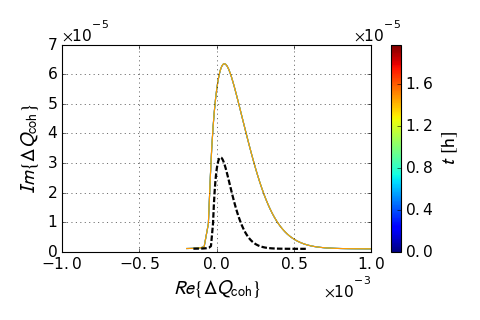

<IPython.core.display.Javascript object>


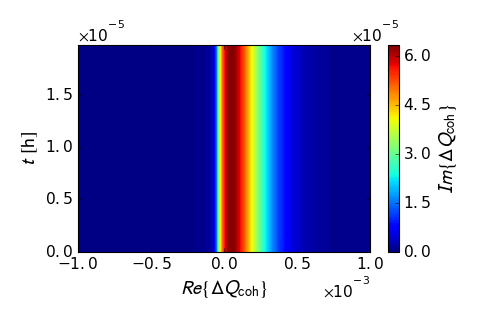

False [ 0.     0.642  1.284  1.927  2.569  3.211  3.853  4.496  5.138  5.78
  6.422  7.065  7.707  8.349  8.991  9.634 10.276 10.918 11.56  12.203
 12.845 13.487 14.129 14.772 15.414 16.056 16.698 17.341 17.983 18.625
 19.267 19.91  20.552 21.194 21.836 22.479 23.121 23.763 24.405 25.048
 25.69  26.332 26.974 27.617 28.259 28.901 29.543 30.186 30.828 31.47
 32.112 32.755 33.397 34.039 34.681 35.324 35.966 36.608 37.25  37.893
 38.535 39.177 39.819 40.462 41.104 41.746 42.388 43.031 43.673 44.315
 44.957 45.6   46.242 46.884 47.526 48.169 48.811 49.453 50.095 50.738
 51.38  52.022 52.664 53.307 53.949 54.591 55.233 55.876 56.518 57.16
 57.802 58.445 59.087 59.729 60.371 61.014 61.656 62.298 62.94  63.583]


In [355]:
bool_save = 0
bool_SD_constituents=0
bool_fill =0
def plot_stability(tune_shifts_all,tunes_Q_all,tune_shifts_calculated,ts,time_scale,savedir,figname):
    fig, ax = plt.subplots(1)#, figsize=(16, 15))
    # col = sns.color_palette("husl", len(tsODE), 0.6)

    # Set colorbar as time measurement:
    norm = mpl.colors.Normalize(vmin=ts.min()/time_scale, vmax=ts.max()/time_scale)
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
    cmap.set_array([])
    
    for i,t in enumerate(ts):
#         if i%2==0:continue
        if not tune_shifts_calculated[i] or t==ts[-1]: continue
        if bool_fill:
            ax.fill(np.concatenate((tune_shifts_all[i].real,tune_shifts_all[i+1][::-1].real)),
                    np.concatenate((tune_shifts_all[i].imag,tune_shifts_all[i+1][::-1].imag)),
                    color=cmap.to_rgba(t/time_scale))
                #,label=r'$t=%.2f$ $%s$'%(t/time_scale,tlabel[6:-2]))
        else :
#         elif 1:
            ax.plot(tune_shifts_all[i].real, tune_shifts_all[i].imag, c=cmap.to_rgba(t/time_scale)) 
    #         ax.fill_between(tune_shifts_all[i].real,tune_shifts_all[i].imag,tune_shifts_all[i+1].imag,
    #                         color=cmap.to_rgba(t/time_scale),interpolate=True)



    ax.set_xlabel("$\operatorname{Re}\{ \Delta Q_\mathrm{coh}\}$")#, fontsize=20)
    ax.set_ylabel("$\operatorname{Im}\{ \Delta Q_\mathrm{coh}\}$")#, fontsize=20)
#     ax.legend(loc=0)
    ax.grid(True)
    #finish colorbar
    cb=fig.colorbar(cmap,label=tlabel) #ticks = np.linspace(0,tmax/time_scale,4),
    tick_locator = mpl.ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    fig.tight_layout()
    
    
    if bool_save: fig.savefig(savedir+'%s.eps'%(figname))
    
    ####################################################################################
    ####################################################################################
    if bool_SD_constituents:
        fig2,ax2 =plt.subplots(2,1,sharex=True)
        # Set colorbar as time measurement:
        norm = mpl.colors.Normalize(vmin=ts.min()/time_scale, vmax=ts.max()/time_scale)
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
        cmap.set_array([])

        for i,t in enumerate(ts):
            if not tune_shifts_calculated[i] or t==ts[-1]: continue
            Q =  tunes_Q_all[i]
            ax2[0].plot(Q/a_x,tune_shifts_all[i].real-Q, c=cmap.to_rgba(t/time_scale)) 
            ax2[1].plot(Q/a_x,tune_shifts_all[i].imag, c=cmap.to_rgba(t/time_scale)) 
        ax2[0].set_ylabel(r'Real $\Delta Q - Q$')
        ax2[1].set_ylabel(r'Imag $\Delta Q$')
        ax2[1].set_xlabel(r'$J$')
        for i in range(2):
            ax2[i].grid(True)
    #     cb=fig2.colorbar(cmap,label=tlabel) #ticks = np.linspace(0,tmax/time_scale,4),
    #     tick_locator = mpl.ticker.MaxNLocator(nbins=5)
    #     cb.locator = tick_locator
    #     cb.update_ticks()
        fig2.tight_layout()
        fig2.subplots_adjust(hspace=0)
    
    ####################################################################################
    ####################################################################################
        fig2,ax2 =plt.subplots(2,1,sharex=True)
        # Set colorbar as time measurement:
        norm = mpl.colors.Normalize(vmin=ts.min()/time_scale, vmax=ts.max()/time_scale)
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
        cmap.set_array([])

        for i,t in enumerate(ts):
            if not tune_shifts_calculated[i] or t==ts[-1]: continue
            Q =  tunes_Q_all[i]
            ReDQ = tune_shifts_all[i].real
            ImDQ = tune_shifts_all[i].imag
            ReInt= -ReDQ / (ReDQ**2 + ImDQ**2)
            ImInt=  ImDQ / (ReDQ**2 + ImDQ**2)
            ax2[0].plot(Q/a_x, ReInt, c=cmap.to_rgba(t/time_scale)) 
            ax2[1].plot(Q/a_x, ImInt, c=cmap.to_rgba(t/time_scale)) 
        ax2[0].set_ylabel('Real integral')
        ax2[1].set_ylabel('Imag integral')
        ax2[1].set_xlabel(r'$J$')
        for i in range(2):
            ax2[i].grid(True)
    #     cb=plt.colorbar(cmap,label=tlabel) #ticks = np.linspace(0,tmax/time_scale,4),
    #     tick_locator = mpl.ticker.MaxNLocator(nbins=5)
    #     cb.locator = tick_locator
    #     cb.update_ticks()
        fig2.tight_layout()
        fig2.subplots_adjust(hspace=0)

    return fig



def waterfallSD(tune_shifts_all,tune_shifts_calculated,ts,time_scale,basex):
    nt = np.size(ts)
    nx = np.size(basex)
    AllY = np.zeros((nt,nx))
    for i in range(nt):
        if not tune_shifts_calculated[i]: continue
        x = tune_shifts_all[i].real
        y = tune_shifts_all[i].imag
        f = sc.interpolate.interp1d(x,y,kind='linear',bounds_error=False,fill_value=0)
        AllY[i] = f(basex)
    
    fig = plt.figure()
    ax=fig.gca()
    cmap = 'jet'
    lims = [0,min(np.max(AllY),3*np.max(AllY[:,int(nx/2)]))]
    
    levels=np.linspace(lims[0],lims[1],100)
    if np.max(AllY)>levels[-1] and 1:
        levels = np.concatenate((np.linspace(lims[0],lims[1]*.33,100)
                                ,np.linspace(np.max(AllY),lims[1]*.33,100,endpoint=False)[::-1]))
        levels = np.linspace(0,np.max(AllY),200)
        clowratio=.9 # part of colors contained by the low levels
        llowratio = int(np.max(AllY[0,:])/np.max(AllY) * 200 * 2) # number of points for the low levels
        clrlevels= np.concatenate((np.linspace(0,clowratio,llowratio,endpoint=False)
                                  ,np.linspace(clowratio,1,200-llowratio)))
        jet = cm.get_cmap('jet')
        newclrs = jet(clrlevels)
        cmap  = mpl.colors.ListedColormap(newclrs)
        lims[1] = np.max(AllY)
    
#     plt.imshow(np.flipud(AllY),cmap=cmap,aspect='auto', extent=(np.min(basex),np.max(basex),0,np.max(ts)/time_scale)
#                ,interpolation=['quadric','none'][0],vmin=lims[0],vmax =lims[1] )
    print(np.max(AllY)==0,levels*1e6)
    plt.contourf(AllY,cmap=cmap,levels=levels,extent=(np.min(basex),np.max(basex),0,np.max(ts)/time_scale))
    cb = plt.colorbar(label = "$\operatorname{Im}\{ \Delta Q_\mathrm{coh}\}$")
    tick_locator = mpl.ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    
    
    ax.set_xlabel("$\operatorname{Re}\{ \Delta Q_\mathrm{coh}\}$")#, fontsize=20)
    ax.set_ylabel(tlabel)
    fig.tight_layout()
    f
    return fig


######################################################################
######################################################################
savedir = '04_Plots_Diffusion/'
for i in [0,1]:
    figi = plot_stability([tune_shifts_all1,tune_shifts_all2][i],[tunes_Q_all1-0.31,tunes_Q_all2-0.32][i],
                          tune_shifts_calculated,tsSD,time_scale,savedir,
                     figname = 'SD_DJ%s_a%.0e_b%.0e_g%.0e_BC%d_Ioct%.0f_en%.1fum'%(['x','y'][i],
                               a,b,g,bool_BC_xmax,i_octupoles,emittance*1e6))
    
    basex = np.linspace(-1,1,100)*1.0e-3
    figj = waterfallSD([tune_shifts_all1,tune_shifts_all2][i],tune_shifts_calculated,
                    tsSD,time_scale,basex)

    if 1:
        axi = figi.gca()
        axi.plot(tune_shifts_halfI.real, tune_shifts_halfI.imag, c='k',ls='--',lw=2,dashes=(5, 2)
                    ,label=r'$I_\mathrm{oct}=%.0f$ $\mathrm{A}$'%(200))
    #     axi.legend(loc=0)
#         axi.set_ylim(0,np.max(tune_shifts.imag)*4)
        axi.set_xlim(-1e-3*[.5,1][i],1e-3)
        figi.tight_layout()
        
        if bool_save: 
            fname = savedir+'SD_DJ%s_a%.0e_b%.0e_g%.0e_BC%d_Ioct%.0f_en%.1fum_digginglimit'%(['x','y'][i],
                               a,b,g,bool_BC_xmax,i_octupoles,emittance*1e6)
            figi.savefig(fname+'.eps',format='eps', dpi=figi.dpi)
            figi.savefig(fname+'.pdf',format='pdf', dpi=figi.dpi)

            fname = savedir+'SD_DJ%s_a%.0e_b%.0e_g%.0e_BC%d_Ioct%.0f_en%.1fum_waterfall'%(['x','y'][i],
                               a,b,g,bool_BC_xmax,i_octupoles,emittance*1e6)
            figj.savefig(fname+'.eps',format='eps', dpi=figi.dpi)


In [84]:
def plot_integrand(psi,dPsi,Q0,Q,jmax=18):
    distribution = MyDistribution1D( Jb,Jc, psi,dPsi)
    detuning = LinearDetuning(Q0, a_x, a_y)
    dispersion = Dispersion(distribution,detuning,Q,integrator_epsilon/100)
    x = np.linspace(0,jmax,100)
    JX,JY = np.meshgrid(x,x)
    integrand = dispersion.getValue(JX,JY)
    cmap  = 'jet'
    plt.figure()
    plt.imshow(np.flipud(integrand.real),extent=(0,jmax,0,jmax),cmap=cmap)
    plt.colorbar()
    plt.title('Real')
    plt.figure()
    plt.imshow(np.flipud(integrand.imag),extent=(0,jmax,0,jmax),cmap=cmap)
    plt.colorbar()
    plt.title('Imag')
i = 20
plot_integrand(psisJ[i],dPsis[i],0.31,0.31+1.4*a_x,6.5)

NameError: name 'a_x' is not defined

<IPython.core.display.Javascript object>


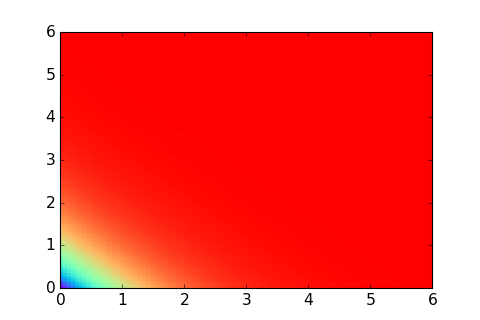

In [28]:
distribution = MyDistribution1D( Jb,Jc, psisJ[0],dPsis[0])
XX,YY = np.meshgrid(np.linspace(0,6,100),np.linspace(0,6,100))
plt.figure()
plt.pcolor(XX,YY,distribution.getDJy(XX,YY))

jet = cm.get_cmap('jet')
levels = np.concatenate((np.arange(10),(np.linspace(11,12,10))))
lev0 =np.min(levels) ;lev1 = np.max(levels)
newclrs = jet((levels-lev0)/(lev1-lev0))
newmap  = mpl.colors.ListedColormap(newclrs)

<IPython.core.display.Javascript object>


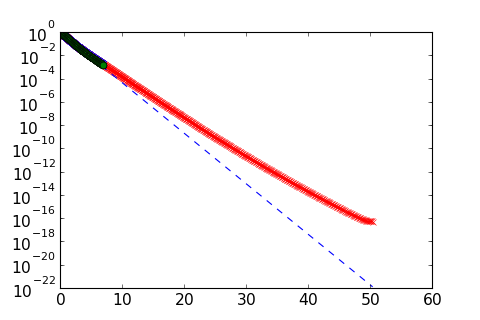

In [30]:
# Simple testing
for i,t in enumerate(tsODE):
    if i!=1: continue
    psiJ = psis[i]
    if bool_radial:
        psiJ = psiJ*rc*h/np.diff(Jb)
    
    dpsi = np.diff(psiJ)/np.diff(Jc)
    plt.figure()
    plt.plot(Jc,psiJ,'rx')
    plt.plot(Jc,np.exp(-Jc),'b--')
    plt.yscale('log')
    
    distribution = MyDistribution1D(Jb,Jc,psiJ,dpsi)
    Js = np.linspace(0,7,200)
    f  = np.zeros_like(Js)
    df = np.zeros_like(Js)
    for j,jx in enumerate(Js):
        f[j] = distribution.getValue(jx,0)
        df[j]= distribution.getDJx(jx,0)
    plt.plot(Js,f,'x')
    plt.plot(Js,-df,'o')

# Plot COMBI results

<IPython.core.display.Javascript object>


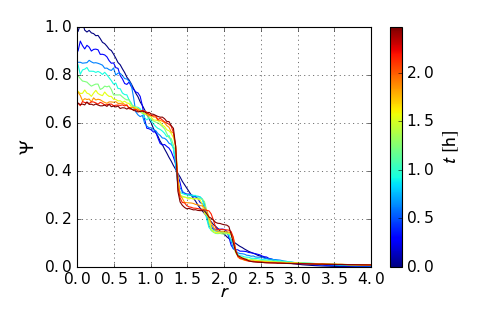

<IPython.core.display.Javascript object>


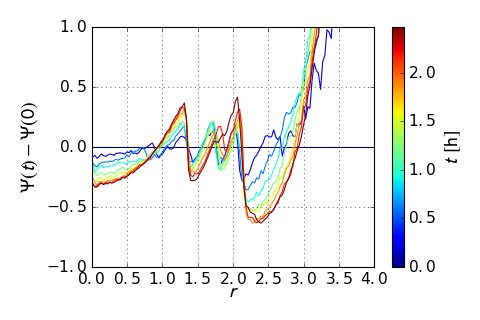

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [346]:
import os
nbin=200
folder = 'dx0.0_N1-5e-03_g2.0e-01_OPa5.0e-03_OPb0.0e+00_Qp0_Qs0.000_np4.0e+06_nt4e+06_dt5e+05'
inputdir = '02_Input/'+folder+'/'
postDist1D_name = inputdir + 'postDistribution1D_nbin%d'%(nbin)
plotdir = '03_Plots'
with open(postDist1D_name,'rb') as pklfile:
    output = pkl.load(pklfile)
SIGMAS = output['sigma0'] 
turns = output['turns']
turnZ = np.max(output['turns'])
PSIS = np.zeros((np.size(turns),nbin-1))
x = edges_to_center(output['bins0Z']*output['rMax'])
for i,turn_i in enumerate(turns):
    for plane in [0]: #Horizontal
        PSIS[i] = output[turn_i]['rAbs'][plane]/x

fig1,ax1,_,_=plot_psis_r(x,np.array(PSIS),np.array(turns)/f_LHC*25,bool_radial,
            D=0,sig0=1,plot_sep=1,bool_theory_g0=0,xmax=4,lw=1,fignradd=11)
ax1.set_ylim(0,1)

fig1.savefig('03_Plots/DDIST_a%.0e_b%.0e_g%.0e_D^2*Nt%.0e_CoNoise.eps'%(
            5e-3,0,0.2,(5e-3)**2*4e6))

[0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000]


<IPython.core.display.Javascript object>


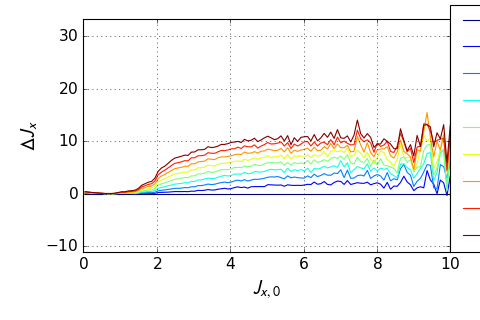

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


<IPython.core.display.Javascript object>


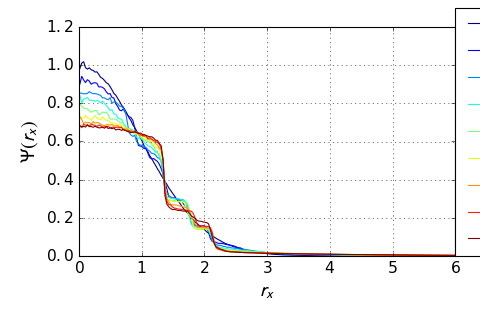

<IPython.core.display.Javascript object>


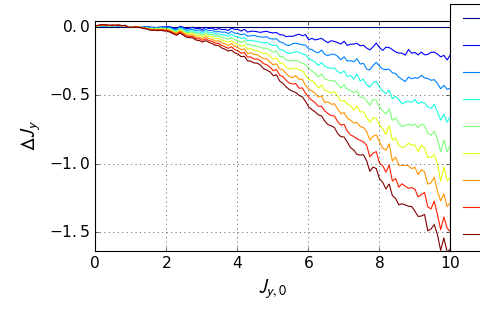

<IPython.core.display.Javascript object>


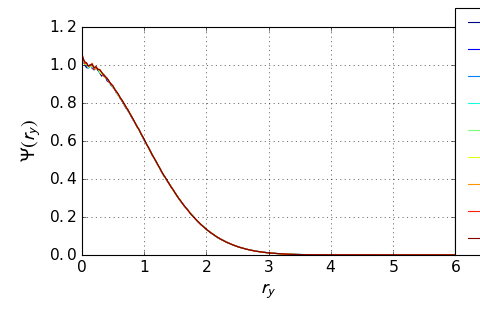

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [74]:




for i,turn_i in enumerate(output['turns']):
    c = cm.jet(turn_i/turnZ)
    lab_turn = '%dk turns'%(turn_i/1000)

    for plane in [0,1]:
        plt.figure(1+plane)
        x = edges_to_center(output['bins0Z']*output['jMax'])
        y = output[turn_i]['djAbs'][plane]
        plt.plot(x,y,c=c,label=lab_turn)
        plt.ylim(min(-np.max(y[x<6]),np.min(y[x<6])*3),np.max(y[x<6])*3)

        plt.figure(4+plane)
        x = edges_to_center(output['bins0Z']*output['rMax'])
        y = output[turn_i]['rAbs'][plane]/x
        plt.plot(x,y,c=c,label=lab_turn)

for plane in [0,1]:   
    xx = ['x','y'][plane]


    plt.figure(1+plane)
    x = edges_to_center(output['bins0Z']*output['jMax'])
    plt.legend(loc=(1,0))
    plt.ylabel(r'$\Delta J_%s$'%xx)
    plt.xlabel(r'$J_{%s,0}$'%xx)
    plt.grid(True)
    plt.xlim(0,10)
    plt.tight_layout()
    plt.savefig(plotdir +'/DDIST_%s_DACT_1D_dJ%s.png'%(folder,xx))

    plt.figure(4+plane)
    plt.legend(loc=(1,0))
    plt.ylabel(r'$\Psi(r_%s)$'%xx)
    plt.xlabel(r'$r_{%s}$'%xx)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(plotdir +'/DDIST_%s_DIST_1D_rad%s.png'%(folder,xx))


# 1D testing

In [350]:
pi2 = 2*np.pi
eps = 1e-2

a = 1e-3
b = 0
g = 1e-2 *0
g2 = g/2 


def trapezoidal(x,y,bool_center=0):
    if bool_center:
        dx = np.diff(x)[0]
        return np.sum(dx*y)
    else:
        return np.sum(np.diff(x)*(y[1:]+y[:-1]))*0.5

def simp(x,y,bool_center=0):
    if bool_center:
        print('CANNOT CALCULATE')
        return np.nan
    else:
        rest = (np.size(x)-1)%2
        dx = np.diff(x)[0]
        add=0
        if rest>0:
            print('N is even, simplify for last point')
            add = dx*0.5 * (y[-1]+y[-2])
            y = y[:-rest]

        return dx/3 * np.sum(y[0:-1:2] + 4*y[1::2] + y[2::2])+add

def edge_to_center(r):
    return 0.5*(r[1:]+r[:-1])

def LL(g2,dmu):
    return (1-g2)**2*(dmu)**2       / (g2**2 + (1-g2)*(dmu)**2)

def dLLdm(g2,dmu):
    return (1-g2)**2*g2**2*2*(dmu)  / (g2**2 + (1-g2)*(dmu)**2)**2

def DD(r,Dnr,Deq=1,Dibs=0,Jxavg = 1):
    D = np.zeros_like(r)
    
    if Dnr == 1:
        D = Deq*np.ones_like(r)
    elif Dnr == 2:
        dq = a * (0.5*r**2-Jxavg) 
        dmu = pi2*dq
        c2 = (1-g2) 
        c3 = g2**2
        lebfac = c2**2*dmu**2 / (c3 + c2*dmu**2)
        L  = LL(g2,dmu)
        dL = dLLdm(g2,dmu)*pi2*a
        lebfac = L
#         lebfac = L*(0.5 + 1.5*(dL<0))
#         lebfac[lebfac<L[0]/100] = L[0]/100          # There is a little noise across the dmu=0 line
#         lebfac = L*(1- dL)                            # subtract 0 -> cannot go negative
#         lebfac = L - np.min([L*1,dL],axis=0)        # subtract 0 -> cannot go negative
#         lebfac = L - np.min([L*.5,dL],axis=0)       # subtract 0 -> cannot go negative

#         lebfac[lebfac<L[0]/100] = L[0]/100          # There is a little noise across the dmu=0 line

        #dmum = pi2*a * (0.5*(r-0.2)**2-Jxavg) 
        #dmup = pi2*a * (0.5*(r+0.2)**2-Jxavg) 
#         lebfac = (lebfac + c2**2*dmum**2/(c3 + c2*dmum**2) + c2**2*dmup**2/(c3 + c2*dmup**2))/3
#         lebfac = L-dL
#         lebfac[lebfac<0] = 0
    
        D = Deq * lebfac
#         D[0.5*r**2<2*Jxavg] = D[0.5*r**2<2*Jxavg]/2 + D[0]/4
    elif Dnr == 3:
        dq = a * (0.5*r**2-Jxavg)
        D = Deq * pi2**2*(1-g2)**2*(dq)**2 / (pi2**2*(1-g2)*(dq)**2  + g2**2)
    elif Dnr == 4:
        J = 0.5*r**2
        q = a * J
        JxDres = 1
        Jxavg = 1
        QIns = a * JxDres
        varQ2= 2*(0.3*a)**2
#         D = DD(r,2,Deq,Jxavg=Jxavg)* (1+50*np.exp(-(q-QIns)**2/varQ2))
        
        An = 4e-3  
        wJ = np.sqrt(An*np.sqrt(JxDres)/a)/1.5 /2
        D0harm = JxDres**(-1/4)*An**(3/2)*a**(-1/2) *3/8    *11245  /2 # factor two as the other Deq is sig^2/2 /2
        P = [1/ (1 + (np.abs(J-JxDres)/wJ)**6), 
             np.exp(-(np.abs(J-JxDres)/wJ)**2),
             np.max([1-((J-JxDres)/(wJ*1.5))**2,np.zeros_like(J)],axis=0)][0]
        D = DD(r,1,Deq,Jxavg=1) + D0harm * P
#         D = DD(r,1,Deq,Jxavg=1) + D0harm* (1 - ((J-1)/wJ_2)**2)*((J-1)**2<wJ_2**2)
    elif Dnr ==5:
        # constant diffusion for J
        D = (Deq)*2  * DD(np.sqrt(2*r),2,1,0) 
        Dibs *=2
    else:
        print('This Diffusion coefficient is not implemented')
    return D+Dibs

def derDD(r,Dnr,Deq=1,Jxavg=1):
    derD = np.zeros_like(r)

    if Dnr == 1:
        derD[:] = 0
    elif Dnr == 2 :
        dq    = a * (0.5*r**2-Jxavg)
        ddqdr = a * (r)
        dmu   = pi2*dq
        ddmudr= pi2*ddqdr
        c2 = (1-g2) 
        c3 = g2**2
        derD[:] = Deq * c2**2 * c3 * 2*dmu/(c3 + c2*dmu**2)**2 * ddmudr
    elif Dnr==3:
        dq1 = (0.5*(r+eps)**2 -1)*a
        dq2 = (0.5*(r-eps)**2 -1)*a
        derD[:] = Deq * (pi2**2*(1-g2)**2*(dq1)**2 / (pi2**2*(1-g2)*(dq1)**2  + g2**2) \
                      -pi2**2*(1-g2)**2*(dq2)**2 / (pi2**2*(1-g2)*(dq2)**2  + g2**2)) / (2*eps) 
    elif Dnr==4:
        derD[:] = (DD(r+eps,Dnr,Deq,Dibs,Jxavg)-DD(r-eps,Dnr,Deq,Dibs,Jxavg))/(2*eps)
    elif Dnr ==5:
        # constant diffusion for J
        derD *= 0
        
    else:
        print('This Diffusion coefficient is not implemented')
    
    return derD

def preDers(r,Dnr,Deq,Dibs,bool_timeDependent=False,psi=0):
    Jxavg = 1
    if bool_timeDependent:
        Jxavg = trapezoidal(r,0.5*r**2 *r*psi)
        Jxavg = 1+(Jxavg-1)*.5
#         print('Avg Jx = %.2f'%Jxavg)
    
    preDer2 = DD(r,Dnr,Deq,Dibs,Jxavg) + Dibs
    
    
    preDer1a = derDD(r,Dnr,Deq,Jxavg)
    if r[0]==0:
#         preDer1b = np.concatenate(([0],preDer2[1:]/r[1:]))
        preDer1b = np.concatenate(([preDer2[1]/r[1]],preDer2[1:]/r[1:]))
    else:
        preDer1b = preDer2/r
    preDer1 = preDer1a*1. + preDer1b

    preDer1 = preDer1[:,np.newaxis]  ; preDer2 = preDer2[:,np.newaxis]  
    return preDer1, preDer2 , preDer1a , preDer1b


def plot_preDers(r,Dnr,Deq,Dibs,bool_timeDependent=False,psi=0,fignradd=0):
    preDer1,preDer2,derD,_ = preDers(r,Dnr,Deq,Dibs,bool_timeDependent,psi)
        
    plt.figure(99+fignradd)
    # plt.plot(r,preDer2,label='D*')
    plt.plot(r,preDer2,label='D')
    plt.plot(r,preDer1,label='dD/dr')
    plt.legend()
    
    plt.plot(r,preDer2*S_Cummel(r[1]-r[0],preDer1,preDer2),'--')
    
# def limit(r,psi):
#     limiter = np.zeros_like(r)
#     diff = np.diff(psi)
#     ratio = np.abs
    
def limiter(psi,dr=1,dt=1,Deq=1):
    diff  = np.abs(np.concatenate(([0],np.diff(psi),[0])))
    diff = 200*(diff[1:]+diff[:-1])/dr*dt*Deq
#     diff = (diff[1:]/diff[:-1])
    return np.exp(-diff**2)[:,np.newaxis]

def S_Cummel_P(P):
    return (1.+ P-1+2*P/(np.exp(2*P)-1))

def S_Cummel(dr,preDer1,preDer2,method=1):
    P = np.abs(dr*preDer1/(2*preDer2))
    if method==1:
        return (1.+ P-1+2*P/(np.exp(2*P)-1))
    else:
        return (1.+ P)#-1+2*P/(np.exp(2*P)-1))

    
# New attempt at lebedev reduction of efficient kick...
# def LL(J,g,a):
#     dmu = pi2*a*(J-1)
#     g2 = func_g2(g)
#     return (1-g2)**2*(dmu)**2 / (g2**2 + (1-g2)*(dmu)**2)

# def LLfromNN(J0,g,a):
#     dmu0 = pi2*a*(J0-1)
#     ddmu0= pi2*a
#     g2 = func_g2(g)
#     return 2*J0*(1-g2)*(1-g/4)*g2**2*2*dmu0*ddmu0 / (g2**2 + (1-g2)*(dmu0)**2)**2

def lebDrift(J0,g,a):
    ddmu0= pi2*a
    dmu0 = ddmu0*(J0-1)
    g2 = g/2
    c2 = (1-g2)
    LL = c2**2*(dmu**2)/(g2**2  + c2*dmu**2)
    LLnew = 2*J0*c2*(1-g/4)*g2**2*2*dmu0*ddmu0 / (g2**2 + (1-g2)*(dmu0)**2)**2
    return  LL + LLnew * .5

def lebDiff(dmu,g):
    g2 = g/2
    c2 = (1-g2)
    c4 = (1-g2/2)
    return c2**2*(dmu**2*g2**2 + c4**2*dmu**4)/(g2**2  + c2*dmu**2)**2

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


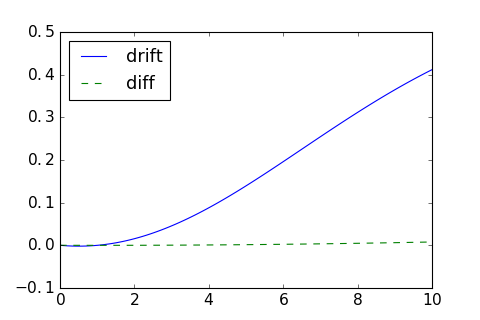

[      0.        701.824    1247.601    1636.441    1867.604    1940.495
    1854.671    1609.839    1205.858     642.739     -79.356    -960.11
   -1999.058   -3195.581   -4548.911   -6058.13    -7722.173   -9539.829
  -11509.742  -13630.414  -15900.209  -18317.354  -20879.939  -23585.928
  -26433.153  -29419.325  -32542.034  -35798.754  -39186.847  -42703.565
  -46346.059  -50111.381  -53996.487  -57998.244  -62113.437  -66338.769
  -70670.867  -75106.293  -79641.541  -84273.049  -88997.198  -93810.324
  -98708.718 -103688.633 -108746.29  -113877.883 -119079.582 -124347.543
 -129677.906 -135066.806 -140510.378 -146004.755 -151546.08  -157130.509
 -162754.212 -168413.382 -174104.234 -179823.016 -185566.005 -191329.519
 -197109.914 -202903.589 -208706.995 -214516.628 -220329.042 -226140.846
 -231948.708 -237749.358 -243539.591 -249316.267 -255076.316 -260816.737
 -266534.603 -272227.059 -277891.326 -283524.701 -289124.559 -294688.353
 -300213.616 -305697.959 -311139.077 -316534.743 -32

In [341]:
J = np.linspace(0,10,100)
atemp=1e-4
gtemp=0.02
dmu = atemp*(J-1)
plt.figure()
drift = lebDrift(J,gtemp,atemp)
diff  = lebDiff(dmu,gtemp)
plt.plot(J,drift,label='drift')
#plt.plot(J,drift**.5,label='drift^.5')
plt.plot(J,diff,'--',label='diff')
#plt.plot(J,diff*J,':',label='diff*J')
#plt.yscale('log')
plt.legend(loc=0)
print((diff-drift)*1e6)
print(drift*1e6)

In [199]:
# Boundary conditions
# def dirchlet(A,b,side,val):
#     if side==1: #Right side
#         b+=A[-1,:]*val
# def homNeumann()

def dirichlet(M,side):
    if side == 0:
        M[0,:]  = 0
    if side == 1:
        M[-1,:] = 0
    return M

def homNeumann(M1,M2,side):
    if side == 0:
        M1[0,:]=0
        M2[0,1] = 2*M2[0,1]
    elif side ==1:
        M1[-1,:]=0
        M2[-1,-2] = 2*M2[-1,-2]
    return M1,M2

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


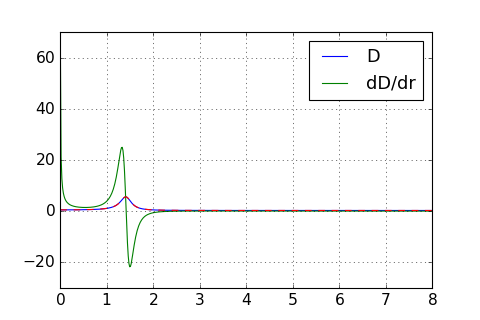

<IPython.core.display.Javascript object>


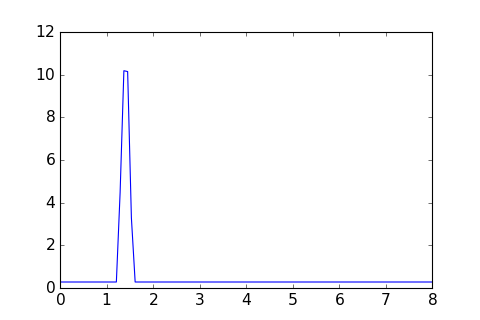

0.21081851067789195


In [342]:
Dnr = 4
plot_preDers(r,Dnr,Deq,Dibs,0)
# plot_preDers(r,Dnr,Deq,Dibs,1,psi)
# P = np.abs(dr*preDer1/(2*preDer2))
# plt.plot(r,P)
plt.grid(True)

plt.figure()
r=np.linspace(0,8,100)
J = 0.5*r**2
An = 4e-3 *1
JxDres=1
wJ_2 = np.sqrt(An*np.sqrt(JxDres)/a)/3
D0harm = JxDres**(-1/4)*An**(3/2)*a**(-1/2) *3/8    *11245
D = DD(r,1,Deq,Jxavg=1) + D0harm/ (1 + ((J-1)/wJ_2)**4)
D = DD(r,1,Deq,Jxavg=1) + D0harm* (1 - ((J-1)/wJ_2)**2)*((J-1)**2<wJ_2**2)
plt.plot(r,D)
print(wJ_2)

/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


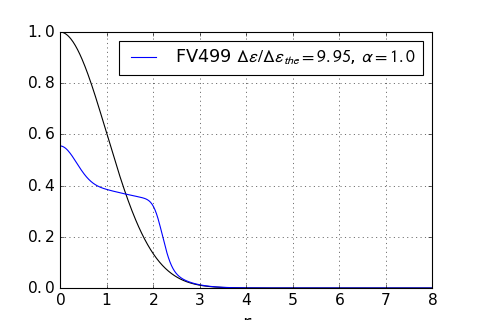

In [351]:
# Plotting
bool_plotOnce = 0
if not bool_plotOnce:
    plt.figure(6)
    plt.xlabel('r')
    plt.grid(True)

In [352]:
sq3 = np.sqrt(3)
pi = np.pi

bool_Dirichlet = 0
bool_timeDependentDiffCoeff = 0
bool_IncoNoise = 0
bool_conservative = 0
bool_smooth    = 0
bool_nopeak    = 0 # set derD[derD<0] = 0 -> still got a peak from below though... 
smoothFac      = 0.9999
iteration_scheme = 5 #[explicit euler, implicit euler, crank nicholson,...,odeint]
discretization_scheme = 2 #[0,FD, FV]
differentialEq = 3
alpha=1

bool_limitFV = 0
Dnr = 4 # [0,Constant, Lebedev ,...,action]
if differentialEq==4:
    Dnr=5

bool_smoothD = 0
bool_semiInco= 0
semiIncoFac = .2

Nr = 500
nturns = int(1e3) *.8
# nturns = 11 * 3.6 *1e6 *1 * 1e-5
noise = 1e-2 *sq3 
signoise=noise/sq3



#################################
### Initiate Space Separation ###
L = 8
if Dnr == 5:
    L = .5*L**2


r = np.linspace(0,L,Nr)
dr= np.diff(r)[0]
#temp for SD
Jb = 0.5*r**2
Jc = edge_to_center(Jb)
rb = r
rc = edge_to_center(rb)
if discretization_scheme == 2:
    # Finite volume
    Ne = Nr
    Nr = Ne-1
    rEdge = r
    r = edge_to_center(rEdge)
    

f_lhc = 11245 *1




Deq=1/4*signoise**2*f_lhc     # Coherent diffusion noise 
Dibs = Deq*0.01*bool_IncoNoise        # Incoherent diffusion noise: Intra beam scattering

lebfac=1
if g!=0 and Dnr!=1:
    lebfac = integrate.nquad(int_octu_leb, [[0,np.inf], [0,np.inf]],args=(a,b,g))[0]

if bool_smoothD:
    Deq *= lebfac
    Dnr=1
elif bool_semiInco :
    Dibs = Deq*lebfac * semiIncoFac
    Deq *= (1-semiIncoFac)
    
D = Deq+Dibs
    
print('Deq ',Deq, Deq*lebfac)
print('Dibs',Dibs)
print('Expected emittance growth/h',2*D*3600, .5*signoise**2*f_lhc*3600,2*D*3600*lebfac)
emittexpect = .5*signoise**2*nturns
print('Expected emittance growth/1e5 turns',2*D/f_lhc*1e5, emittexpect,emittexpect*lebfac)


################################
#### Initiate time iteration ###
C = 1
dt = C*dr**2/Deq
# CFL = 1
# dt= CFL*dr/np.max(preDer1)
# print('CFL',np.max(preDer1)*dt/dr)
day1 = 24*3600
tmax = min(day1,15000*dt)  
tmaxODE =nturns/f_lhc #24*3600

# tmax = 24*3600
nt = max(int(np.ceil(tmax/dt)),3)
ts = np.linspace(0,tmax,nt)
tsode = np.linspace(0,tmaxODE,9)
dt = np.diff(ts)[0]
sig=1

tsODE = tsode
nt = np.size(tsODE)

print('dt  ',dt)
print('nt  ',nt)
print('tmax',tmax/3600)
print('tmaxODE',tmaxODE/3600)
print('1/(1+2Dt)',1/(1+2*(Deq+Dibs)*tmaxODE))

# Initial distribution
# if discretization_scheme==1:
psi0  =1/sig**2*np.exp(-0.5*r**2/sig**2)
if Dnr==5:
    psi0 = 1/sig*np.exp(-r/sig)
psis = np.zeros((nt,Nr))
psi = psi0
# elif discretization_scheme==2:
#     psi0FV=1/sig**2*np.exp(-0.5*r**2/sig**2)
#     psis = np.zeros((nt,Nc))
#     psi = psi0FV
    
psis[0,:]=psi

#################################
### Finish Space Separation ###
# Finite difference:
if discretization_scheme==1:
    upwind = ( np.eye(Nr) -np.eye(Nr,k=-1))/dr
    dnwind = (-np.eye(Nr) +np.eye(Nr,k=1))/dr
    upwind2= ( 3*np.eye(Nr) -4*np.eye(Nr,k=-1)+np.eye(Nr,k=-2))/(2*dr)
    dnwind2= (-3*np.eye(Nr) +4*np.eye(Nr,k=1) -np.eye(Nr,k=2))/(2*dr)
    upwind2[:2,:2]  =upwind[:2,:2] ; dnwind2[-2:,-2:]=dnwind[-2:,-2:]
    centered=(np.eye(Nr,k=1)-np.eye(Nr,k=-1))/(2*dr)
    
    preDer1,preDer2 = preDers(r,Dnr,Deq,Dibs,0)[:2]
    vp = (preDer1<0)
    vm = (preDer1>0)


    # der1 = (upwind *vp + dnwind *vm)
    # der1 = (upwind2*vp + dnwind2*vm)
    der1= centered 
    # preDer1 = preDer1/S_Cummel(dr,preDer1,preDer2,2)
    # print(S_Cummel(dr,preDer1,preDer2,1))
    # print(preDer1.T)
    if np.any(preDer2==0):
        print("OBS: Zero diffusion")
        preDer2[preDer2==0]+=1e-9
    # print(S_Cummel(dr,preDer1,preDer2,1).T)
    preDer2 = preDer2*S_Cummel(dr,preDer1,preDer2,1)
    der2 = (np.eye(Nr,k=-1)+np.eye(Nr,k=1)-2*np.eye(Nr))/(dr**2)




    # der1a = (np.eye(Nr) + np.eye(Nr,k= 1))/(2*dr)
    # der1b =-(np.eye(Nr) + np.eye(Nr,k=-1))/(2*dr)
    # A1 = der1a*(v[1:,np.newaxis]) + der1b*(v[:-1,np.newaxis])


    if 0:
        Jxavg=1
        redge = r[:-1]+np.diff(r)*0.5
        preDer1Edge = derDD(redge,Dnr,Deq,Jxavg) + DD(redge,Dnr,Deq,Dibs,Jxavg)/redge
        v = np.concatenate(([0],-preDer1Edge,[0]))
        vp = v>=0
        vn = v<0
        vvp=(v*vp)[np.newaxis,1:]
        vvm=(v*vn)[np.newaxis,:-1]
        vvp=(v*vp)[1:,np.newaxis]
        vvm=(v*vn)[:-1,np.newaxis]
        flux2 = -(upwind)*(vvp) \
                -(dnwind)*(vvm)
        A1 = flux2





    # A1 = preDer1*(preDer1>0)*upwind + preDer1*(preDer1<0)*dnwind


    A1 = preDer1*der1
    A2 = preDer2*der2
    homNeumann(A1,A2,0)
    homNeumann(A1,A2,1)
    homNeumann(der1,der2,0)
    homNeumann(der1,der2,1)
    
    # A = preDer1*der1 + preDer2*der2
    A = A1+ A2

elif discretization_scheme==2:
    if differentialEq ==1:
        # Finite volume
        der1L = ( np.eye(Nr) -np.eye(Nr,k=-1))/dr
        der1R = (-np.eye(Nr) +np.eye(Nr,k=1))/dr
        der2 = (np.eye(Nr,k=-1)+np.eye(Nr,k=1)-2*np.eye(Nr))/(dr**1)

        coeffEdge=-rEdge*DD(rEdge,Dnr,Deq,Dibs)
#         print('test',coeffEdge*1e3)
    #     if not bool_Dirichlet: #Neumann
    #         coeffEdge[-1]=0
    #     elif bool_Dirichlet: #Dirichlet
    #         coeffEdge[-2]=0
        FVRe = -coeffEdge[1:,np.newaxis]*der1R
        FVLe = -coeffEdge[:-1,np.newaxis]*der1L

        FVD = 0
        if bool_limitFV:
            aa=coeffEdge[1:,np.newaxis]
            bb=coeffEdge[:-1,np.newaxis]
            P = (bb-aa)/(bb+aa)
            FVD = +(0.5*(aa+bb)*(S_Cummel_P(P)-1))*der2
    #         R = np.diff(psi0)[:-1]/np.diff(psi0)[1:]

        FV = (FVRe-FVLe +FVD)/ (dr*r[:,np.newaxis])  
        if Dnr==5:
            FV = (FVRe-FVLe +FVD)/ (dr)

        if not bool_Dirichlet: #Neumann
            print('None')
            FV[-1,-1]=-FV[-1,-2]
        if bool_Dirichlet: #Dirichlet
            FV[-1,:]=0

        print('TEST',coeffEdge.shape,der1L.shape)

    elif differentialEq ==2:
        # Finite volume
        der1L = ( np.eye(Nr) -np.eye(Nr,k=-1))/dr
        der1R = (-np.eye(Nr) +np.eye(Nr,k=1))/dr
        coeffEdge=rEdge
        FVRe = coeffEdge[1:,np.newaxis]*der1R
        FVLe = coeffEdge[:-1,np.newaxis]*der1L

        Javg = trapezoidal(rEdge,r*psi*r**2 / 2,discretization_scheme==2)
        print('Jxavg',Javg)
        FV = (FVRe-FVLe)/ (dr*r[:,np.newaxis]) *(DD(r,Dnr,Deq,Dibs,Jxavg=Javg))#[:,np.newaxis]

        if discretization_scheme == 5 : #
            print('Not implemented')
            
    elif differentialEq in [3,5]:
        # Matrices
        der1L = ( np.eye(Nr) -np.eye(Nr,k=-1))/dr
        der1R = (-np.eye(Nr) +np.eye(Nr,k=1))/dr
        avgL = ( np.eye(Nr) + np.eye(Nr,k=-1))/2
        avgR = ( np.eye(Nr) + np.eye(Nr,k=1))/2
        
        # Coefficients
        DEdge = DD(rEdge,Dnr,Deq,Dibs)
        derDEdge = (DD(rEdge+eps,Dnr,Deq,Dibs) - DD(rEdge-eps,Dnr,Deq,Dibs))/(2*eps)
        
        if bool_nopeak: derDEdge[derDEdge<0]=0
        
        coeffEdge=rEdge*DEdge
#         FV_diff =(coeffEdge[1:,np.newaxis]*der1R \
#                   coeffEdge[:-1,np.newaxis]*der1L) / (r*dr)
        
        
#         FV_drift
        
#         coeff0Diff0 = np.concatenate(([0],rEdge*DEdge,[0]))
        FV_diff = (np.diag((rEdge*DEdge)[1:-1],k=1)
                  -np.diag((rEdge*DEdge)[1:]+(rEdge*DEdge)[:-1],k=0)
                  +np.diag((rEdge*DEdge)[1:-1],k=-1)) /(r[:,np.newaxis]*dr**2)
        
        FV_drift =(np.diag((rEdge*derDEdge)[1:-1],k=1)
                  +np.diag((rEdge*derDEdge)[1:]-(rEdge*derDEdge)[:-1],k=0)
                  -np.diag((rEdge*derDEdge)[1:-1],k=-1)) /(2*r[:,np.newaxis]*dr) * (1-alpha)
        
        FV = FV_diff + FV_drift
        
        if differentialEq == 5:
            FV = FV_diff - .5*np.diag(.5*r*(DD(r+eps,Dnr,Deq,Dibs) - DD(r-eps,Dnr,Deq,Dibs))/(2*eps),k=0)
            
    elif differentialEq == 4:
        # 'r' = J 
        D0 = signoise**2/2 *f_lhc 
        dmu = pi2*a*(r-1) 
        
        Ddiff = D0*lebDiff(dmu,g)
        colcoeffDiff = r*Ddiff
        der2 = (np.eye(Nr,k=-1)+np.eye(Nr,k=1)-2*np.eye(Nr))/(dr**2)
#         der2[0,0]=-der2[0,1]
        
        #dmuEdge =pi2*(a*rEdge-1)
        Ddrift = D0*lebDrift(r,g,a)
        colcoeffDrift = Ddrift
        der1 = (-np.eye(Nr,k=-1)+np.eye(Nr,k=1))/(2*dr**1)
#         der1[0,0] = der1[0,1]
        
        
         #[:,np.newaxis] #<- use this when rho_(t,i) depend on one value
        FV = der2*(colcoeffDiff) - der1*(colcoeffDrift)
        FV[0,1] = colcoeffDrift[1]/dr
        FV[0,0] = -FV[0,1]
        
        
        # If U=D
#         rP = rEdge[1:]
#         rM = rEdge[:-1]
#         der1L = ( np.eye(Nr) -np.eye(Nr,k=-1))/dr*rM
#         der1R = (-np.eye(Nr) +np.eye(Nr,k=1 ))/dr*rP
        
#         FV = der1L*(Ddrift[:,np.newaxis])
        
    
        
if bool_plotOnce:
    plt.figure(5)
    plt.xlabel('r')
else:
    plt.figure(6)


#############################
### Iteration preperation ###
if discretization_scheme==1:
    if bool_Dirichlet:
        A1 = dirichlet(A1,1)
        A2 = dirichlet(A2,1)
        A = A1+A2

    I    = np.eye(Nr)
    IE_A = I-dt*A
    CN_A = I-0.5*dt*(A1+A2)
    CN_B = I+0.5*dt*(A1+A2)

    # A1 = preDer1*der1
    limit = limiter(psi,dr,dt,Deq)
    S_A=I-0.5*dt*(A2+A1*limit)
    S_B=I+0.5*dt*(A2+A1*limit)

    
    def dpsidt(psi,t,r,A1=A1,A2=A2):
        if bool_timeDependentDiffCoeff:
            preDer1,preDer2 = preDers(r,Dnr,Deq,Dibs,True,psi)[:2]

            #Add numerical viscosity
            if np.any(preDer2==0):
                print("OBS: Zero diffusion")
                preDer2[preDer2==0]+=1e-9
            preDer2 = preDer2*S_Cummel(dr,preDer1,preDer2,1)

            A1 = preDer1*der1 ; A2 = preDer2*der2
            if bool_Dirichlet:
                A1 = dirichlet(A1,1)
                A2 = dirichlet(A2,1)
        return (A1+A2).dot(psi)
    
elif discretization_scheme == 2:
    if differentialEq==1:
        def dpsidtFV(psi,t,r,A=FV):
            if bool_timeDependentDiffCoeff:
                None
            return A.dot(psi)
    if differentialEq in [2,3,4,5]:
        # This is not physically relevant
        def dpsidtFV(psi,t,r,A=FV):
            # Javg = trapezoidal(rEdge,r*psi*r**2 / 2,discretization_scheme==2)
            #A = A*(DD(r,Dnr,Deq,Dibs,Jxavg=Javg)[:,np.newaxis])
            #psi[1:-1] = psi[1:-1]*smoothFac + .5*(1-smoothFac)*(psi[2:]+psi[:-2])
            return A.dot(psi)
    
        

        
#################
### Iteration ###        
if iteration_scheme!=5:
    for i,t in enumerate(ts):
        if i>0:
            # Update D,dD/dr,D/r
            if bool_timeDependentDiffCoeff:
                preDer1,preDer2 = preDers(r,Dnr,Deq,Dibs,True,psi)[:2]
                A1 = preDer1*der1 ; A2 = preDer2*der2
                if bool_Dirichlet:
                    A1 = dirichlet(A1,1)
                    A2 = dirichlet(A2,1)
                A = A1+A2

                I    = np.eye(Nr)
                IE_A = I-dt*A
                CN_A = I-0.5*dt*A
                CN_B = I+0.5*dt*A


            if iteration_scheme==1:
                psi += dt*A.dot(psi)
            elif iteration_scheme==2:
                psi = np.linalg.solve(IE_A , psi)
            elif iteration_scheme==3:
                psi = np.linalg.solve( CN_A,CN_B.dot(psi))

            elif iteration_scheme==4:
                limit = limiter(psi,dr,dt,Deq)
                S_A=I-0.5*dt*(A2+A1*limit)
                S_B=I+0.5*dt*(A2+A1*limit)
                psi = np.linalg.solve( S_A,S_B.dot(psi))

            if not bool_Dirichlet and bool_conservative:
                psi*=1/simp(r,r*psi)

        if bool_smooth:
            psi[1:-1] = psi[1:-1]*smoothFac + .5*(1-smoothFac)*(psi[2:]+psi[:-2])
        psis[i,:]=psi
        if i%10==0 :
            plt.plot(r,psi)

else:
    ts=tsode
    print('tsode',tsode)
    
    if discretization_scheme==1:
        psis = sc.integrate.odeint(dpsidt,psi0,tsode,args=(r,))
        psis1D=psis    
    elif discretization_scheme==2:
        psis = sc.integrate.odeint(dpsidtFV,psi0,tsode,args=(r,))
        psis1D=psis    
        
        
# Calculate emittance
if discretization_scheme==1:
    emittafter = simp(r,r*psis[-1,:] *r**2 / 2,discretization_scheme==2)
elif discretization_scheme==2:
    emittafter = trapezoidal(rEdge,r*psis[-1,:] *r**2 / 2,discretization_scheme==2)
if Dnr==5:
    emittafter = trapezoidal(rEdge,psis[-1,:] *r,discretization_scheme==2)
print('Emittance=%.4e | growth=%.2e | expgrowth=%.2e | ratio=%.3f'%(emittafter , emittafter-1, emittexpect*lebfac,(emittafter-1)/(emittexpect*lebfac)))

        
#Plotting
if iteration_scheme!=5:
    plt.plot(r,psi,label='t=%f'%tmax)
    D = DD(r,1,Deq,Dibs)*1
    psitheory = 1/(sig**2 + 2*D*tmax)*np.exp(-0.5*r**2/(sig**2 + 2*D*tmax))
    plt.plot(r,psitheory,':',lw=2)
else:
    x = r
    if Dnr==5:
        x= np.sqrt(2*r)
    print(x)
#    print(psis1D[-1,0:4],psis1D[-1,-4:])
    plt.plot(x,psis1D[0,:],'k')
    #plt.plot(r,psis1D[1,:],label=['FD','FV'][discretization_scheme-1]+str(Nr))
    plt.plot(x,psis1D[-1,:],label=['FD','FV'][discretization_scheme-1]+str(Nr)+
             ' $\Delta\epsilon/\Delta\epsilon_{the}=%.2f$'%((emittafter-1)/(emittexpect*lebfac))+
             ['',r', $\alpha=%.1f$'%alpha][differentialEq==3])
    plt.legend(loc=0)
#     plt.close(1)






# Testing
if discretization_scheme==1:
    None
#    print(preDer1[:15].T*1e6)
#    print(preDer2[:15].T*1e6)
    # print(der1x[:8,:8])
    # print(der2x[:8,:8])
elif discretization_scheme==2:
    None
#     print(rEdge)
    #print(coeffEdge * 1e4)
#     print(FV* 1e4)


# For stability diagram
# Get distribution in J as well
psisJ = psis
if bool_radial:
    psisJ = psisJ[:]*rc*np.diff(rb)/np.diff(Jb)
dPsis = np.diff(psisJ[:])/np.diff(Jc)

Deq  0.281125 0.281125
Dibs 0.0
Expected emittance growth/h 2024.1000000000001 2024.1000000000001 2024.1000000000001
Expected emittance growth/1e5 turns 5.0 0.04 0.04
dt   0.0009143413659177547
nt   9
tmax 0.003809501707611223
tmaxODE 1.976186947285213e-05
1/(1+2Dt) 0.9615384615384615
tsode [0.    0.009 0.018 0.027 0.036 0.044 0.053 0.062 0.071]
Emittance=1.3980e+00 | growth=3.98e-01 | expgrowth=4.00e-02 | ratio=9.950
[0.008 0.024 0.04  0.056 0.072 0.088 0.104 0.12  0.136 0.152 0.168 0.184
 0.2   0.216 0.232 0.248 0.265 0.281 0.297 0.313 0.329 0.345 0.361 0.377
 0.393 0.409 0.425 0.441 0.457 0.473 0.489 0.505 0.521 0.537 0.553 0.569
 0.585 0.601 0.617 0.633 0.649 0.665 0.681 0.697 0.713 0.729 0.745 0.762
 0.778 0.794 0.81  0.826 0.842 0.858 0.874 0.89  0.906 0.922 0.938 0.954
 0.97  0.986 1.002 1.018 1.034 1.05  1.066 1.082 1.098 1.114 1.13  1.146
 1.162 1.178 1.194 1.21  1.226 1.242 1.259 1.275 1.291 1.307 1.323 1.339
 1.355 1.371 1.387 1.403 1.419 1.435 1.451 1.467 1.483 1.499 1.515 

In [317]:
if 0 :
    print(FV*1e3)
    print(1e3*der2*(colcoeffDiff[:,np.newaxis]))
    print(-1e3*der1*(colcoeffDrift[:,np.newaxis]))
    # print(colcoeffDiff[:,np.newaxis]*1e6)
    # print(colcoeffDrift*1e6)

if 0:
    print(FV* 1e4)
    print(FV_drift*1e4)

    print(nt,Nr)
    
# 101: [ 0.626  0.626  0.626  0.626] [ 0.034  0.034  0.034  0.034]
# 201: [ 0.627  0.627  0.627  0.627] [ 0.032  0.032  0.032  0.032]
# 401: [ 0.629  0.629  0.629  0.629] [ 0.033  0.033  0.033  0.033]
# 801: [ 0.631  0.631  0.631  0.631] [ 0.032  0.032  0.032  0.032]

# 200: [ 0.61  0.61  0.61  0.61] [ 0.012  0.012  0.012  0.012]
# 400: [ 0.623  0.623  0.623  0.623] [ 0.012  0.012  0.012  0.012]
# 800: [ 0.628  0.628  0.628  0.628] [ 0.012  0.012  0.012  0.012]

nt=9 , nplots=100 -> plot_sep=1


<IPython.core.display.Javascript object>


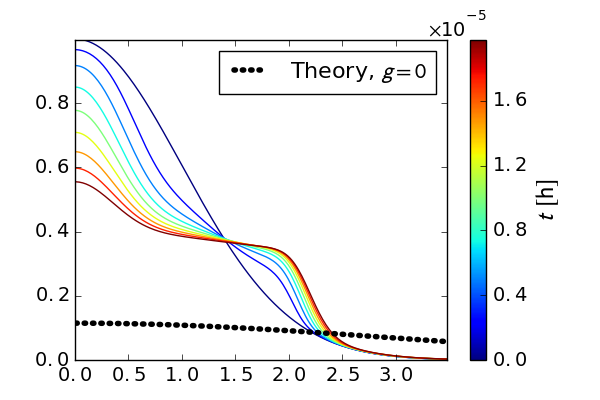

<IPython.core.display.Javascript object>


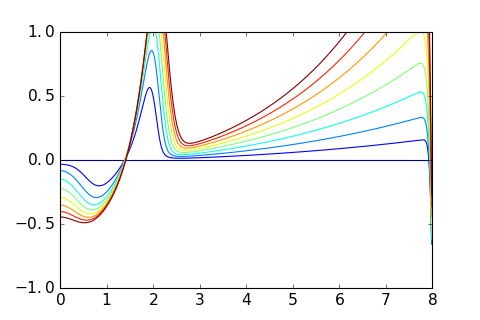

<IPython.core.display.Javascript object>


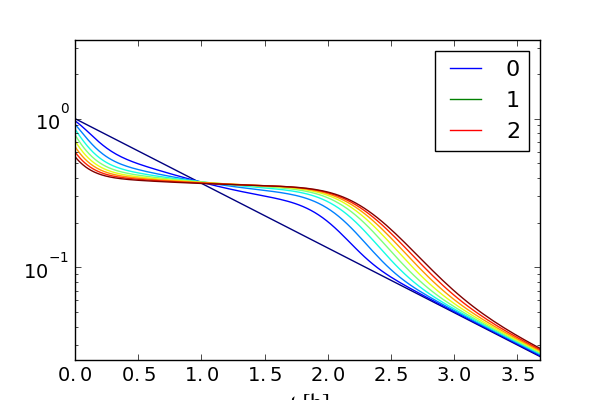

(9,) (9, 4)


/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


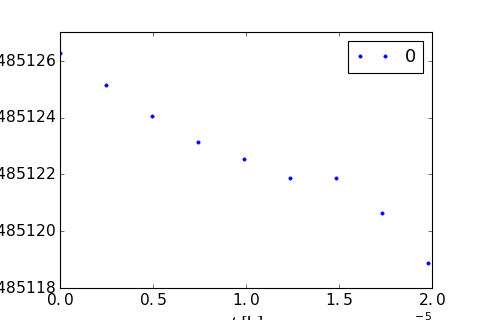

<IPython.core.display.Javascript object>


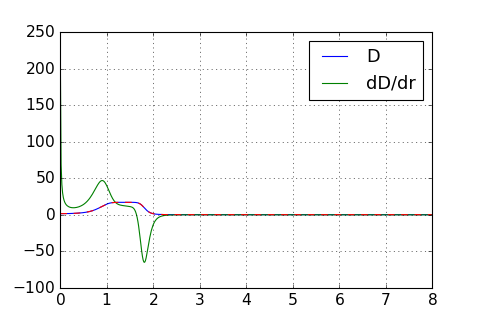

In [353]:
psis=psis1D

# Plotting
time_scale = 1 ;  tlabel=r'$t$ $[\mathrm{sec}]$'
time_scale = 60 ; tlabel=r'$t$ $[\mathrm{min}]$'
time_scale = 3600 ; tlabel=r'$t$ $[\mathrm{h}]$'

nplots=100
plot_sep = int(np.ceil(np.size(ts)/nplots))
print('nt=%d , nplots=%d -> plot_sep=%d'%(nt,nplots,plot_sep))

fig1, ax1 = plt.subplots(dpi=100,num=10)
norm = mpl.colors.Normalize(vmin=ts.min()/time_scale, vmax=ts.max()/time_scale)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])


fig2 = plt.figure(num=11)
ax2 = plt.gca()

fig3, ax3 = plt.subplots(dpi=100,num=12)
norm = mpl.colors.Normalize(vmin=ts.min()/time_scale, vmax=ts.max()/time_scale)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])
ax3.set_xlabel('J')
ax3.set_yscale('log')



moments = np.zeros((ts.size,4))
for i , t in enumerate(ts):
    if discretization_scheme==1:
        moments[i,:] = [simp(r,r*psis[i,:] *r**j / 2,discretization_scheme==2) for j in [0,1,2,3]]
    elif discretization_scheme==2:
        moments[i,:] = [trapezoidal(rEdge,r*psis[i,:] *r**j / 2,discretization_scheme==2) for j in [0,1,2,3]]
    if Dnr ==5:
        moments[i,:] = [trapezoidal(r,psis[i,:] *(r)**(j),0) for j in [0,1,2,3]]

    if i%plot_sep==0:
        ax1.plot(r,psis[i,:], c=cmap.to_rgba(t/time_scale))
        ax2.plot(r,(psis[i,:]-psis[0,:])/psis[0,:], c=cmap.to_rgba(t/time_scale))
        ax3.plot(Jc,psisJ[i,:], c=cmap.to_rgba(t/time_scale))
    
#         print(t/time_scale,np.sum(dr*r*psis[i,:]),np.sum(dr*r*r**2*psis[i,:]))

#ax1.set_yscale('log')

cb=fig1.colorbar(cmap,label=tlabel) #ticks = np.linspace(0,tmax/time_scale,4),
tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

# Theoretical curve
D = Deq+Dibs # DD(r,1,Deq)*1+Dibs
psitheory = 1/(sig**2 + 2*D*tmax)*np.exp(-0.5*r**2/(sig**2 + 2*D*tmax))
if Dnr==5:
    sigt=(sig**2+2*D*tmax)
    psiJtheory = 1/sigt*np.exp(-r/sigt)
    ax1.plot(r,psiJtheory,'--k',lw=4,dashes=[1,5],dash_capstyle='round',label=r'Theory, $g=0$')
else:
    ax1.plot(r,psitheory,'--k',lw=4,dashes=[1,5],dash_capstyle='round',label=r'Theory, $g=0$')
ax1.legend()

ax2.set_ylim([-1,1])

plt.figure(num=12)
print(ts.shape,moments.shape)
for i in range(3):
    
    plt.plot(ts/time_scale,moments[:,i],label=str(i))
plt.xlabel(tlabel)
plt.legend(loc=0)

plt.figure(num=13)
for i in range(1):
    plt.plot(ts/time_scale,moments[:,i],'.',label=str(i))
plt.xlabel(tlabel)
plt.legend(loc=0)


# Plot preders
if Dnr!=5:
    plot_preDers(r,Dnr,Deq,Dibs,1,psis[-1,:],fignradd=1)
# plot_preDers(r,Dnr,Deq,Dibs,1,psi)
plt.grid(True)

Good simulations:
    dx0.0_N1-5e-03_g2.0e-01_OPa1.0e-02_OPb0.0e+00_Qp0_Qs0.000_np1.0e+06_nt5e+05_dt2e+05
        Noise with damper. 
    dx0.0_N4-3e-03_g0.0e+00_OPa0.0e+00_OPb0.0e+00_Qp0_Qs0.000_np1.0e+06_nt1e+05_dt5e+04
        Gaussian noise. Clearly see buildup in the tail

In [301]:
ANoise=1e-4
frev = 11245
0.5*ANoise**2*frev*3600

0.20240999999999998

In [302]:
print(A1.shape,A2.shape)
print(A12D.shape,A22D.shape)
print(x.shape,y.shape,r.shape)
# print(A1*1e6)
# print(A2*1e6)
# print(A12D[:8,:8]*1e6)
# print(A22D[:8,:8]*1e6)
# print(psi0)
# print(psi02D.T)

print(psi0)
psi1 = sc.integrate.odeint(dpsidt,psi0,ts,args=(x,A1,A2))
print(psi02D.T[0,:Nx].shape)
psi2 = sc.integrate.odeint(dpsidt2D,psi02D.T[0,:Nx],ts,args=(x,y,A12D[:Nx,:Nx],A22D[:Nx,:Nx]))
psi3 = sc.integrate.odeint(dpsidt2D,psi02D.T[0],ts,args=(x,y,A12D,A22D))

print(ts)
print(psi1)
print(psi2)
print('ic',np.all(psi0==psi02D.T[0,:Nx]))
print(np.all(psi1==psi2))
print(psi3[:,:Nx])


A2D= A12D+A22D
A1D= A1 + A2
print(np.all(A2D[:Nx,:Nx]==A1D))

plt.figure()
plt.imshow(A12D+A22D,cmap='bwr')




NameError: name 'A1' is not defined

# test stuff in python 

In [303]:
a = np.arange(9).reshape(3,3)
b = np.arange(3)

print(a)
print(b)
print(a*b)
print(a*(b[:,np.newaxis]))

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[0 1 2]
[[ 0  1  4]
 [ 0  4 10]
 [ 0  7 16]]
[[ 0  0  0]
 [ 3  4  5]
 [12 14 16]]


# 2D diffusion

In [538]:
eps = 1e-5
ax = 1.64e-4
bx = -ax*190/260 * 1
ay=ax ; by=bx
# ay=by=0
g = 0.0
g2 = g/2
Qs = 0.002

QxIns = bx * 2 #JxQres
QyIns = by * 2

Jxavg = 1
Jyavg = 1

def fQx(Jx,Jy,a=ax,b=bx):
    return a*Jx + b*Jy
def fQy(Jx,Jy,a=ay,b=by):
    return b*Jx + a*Jy

def DD2D(x,y,Dnr,Deqx=1,Deqy=1,Jxavg = 1,Jyavg = 1):
    Dx = np.zeros_like(x)
    Dx[:] = np.nan
    Dy = np.zeros_like(x)
    Dy[:] = np.nan
    
    if Dnr == 1:
        D[:] = Deq
    elif Dnr == 2:
        
        dqx = ax * (0.5*x**2-Jxavg) + bx * (0.5*y**2-Jyavg)
        dqy = by * (0.5*x**2-Jxavg) + ay * (0.5*y**2-Jyavg)
        dmux = pi2*dqx
        dmuy = pi2*dqy
        c2 = (1-g2) 
        c3 = g2**2
        Dx[:] = Deq * c2**2*dmux**2 / (c3 + c2*dmux**2)
        Dy[:] = Deq * c2**2*dmuy**2 / (c3 + c2*dmuy**2)
    elif Dnr == 4:
        qx = ax * (0.5*x**2) + bx * (0.5*y**2)
        qy = by * (0.5*x**2) + ay * (0.5*y**2)
#         Qxavg = fQx(Jxavg,Jyavg)
#         Qyavg = fQy(Jxavg,Jyavg)
#         QxIns=Qxavg-Qs
#         QyIns=Qyavg-Qs
#         JxQres = 1
#         Jxavg  =3

        varQ2= 2*(0.4*max(ax,ay))**2

        Dx,Dy = DD2D(x,y,2,Deqx,Deqy,Jxavg,Jyavg)
#         Dx[:] *= (1+20*np.exp(-(qx-QxIns)**2/varQ2))
#         Dy[:] *= (1+20*np.exp(-(qy-QyIns)**2/varQ2))
        
        # Try resonance 
#         taux= tauy = 2/g
#         taux = 5/np.sqrt(2*ax**2 + 2*ax*bx + 2*bx**2)/pi2 
#         tauy = 5/np.sqrt(2*ay**2 + 2*ay*by + 2*by**2)/pi2
        j=3
        dj = np.sqrt(2*j)*.5*1e-4 # approximate value of change of J per kick
        taux = 1/np.sqrt(2*ax*dj) 
        tauy = 1/np.sqrt(2*ay*dj)
        Dx[:] *= (0 + 2/taux/(1/taux**2  + pi2**2*(qx-QxIns)**2) * 1e-0)
        Dy[:] *= (0 + 2/tauy/(1/tauy**2  + pi2**2*(qy-QyIns)**2) * 1e-0)
    
    else:
        print('This Diffusion coefficient is not implemented')
    return Dx,Dy

def derDD2D(x,y,Dnr,Deqx=1,Deqy=1,Jxavg = 1,Jyavg = 1):
    derDx = np.zeros_like(x)
    derDx[:] = np.nan
    derDy = np.zeros_like(x)
    derDy[:] = np.nan
    if Dnr == 1:
        derDx[:] = 0
        derDy[:] = 0
    elif Dnr == 2 :
        
        dqx = ax * (0.5*x**2-Jxavg) + bx * (0.5*y**2-Jyavg)
        dqy = by * (0.5*x**2-Jxavg) + ay * (0.5*y**2-Jyavg)
        dmux = pi2*dqx
        dmuy = pi2*dqy
        
        ddqxdx = ax * (x)
        ddqydy = ay * (y)
        
        ddmuxdx = pi2*ddqxdx
        ddmuydy = pi2*ddqydy
        
        c2 = (1-g2) 
        c3 = g2**2
        derDx[:] = Deq * c2**2 * c3 * 2*dmux/(c3 + c2*dmux**2)**2 * ddmuxdx
        derDy[:] = Deq * c2**2 * c3 * 2*dmuy/(c3 + c2*dmuy**2)**2 * ddmuydy
    elif Dnr==4:
        derDx[:] = (DD2D(x+eps,y,Dnr,Deqx,Deqy,Jxavg,Jyavg)[0]-DD2D(x-eps,y,Dnr,Deqx,Deqy,Jxavg,Jyavg)[0])/(2*eps)
        derDy[:] = (DD2D(x,y+eps,Dnr,Deqx,Deqy,Jxavg,Jyavg)[1]-DD2D(x,y-eps,Dnr,Deqx,Deqy,Jxavg,Jyavg)[1])/(2*eps)
    else:
        print('This Diffusion coefficient is not implemented')
    
    return derDx,derDy

def preDers2D(x,y,Dnr,Deqx,Deqy,Dibsx,Dibsy,bool_timeDependent=False,psi=0,Jxavg=Jxavg,Jyavg=Jyavg):
    
    if bool_timeDependent:
        print('Not ready for time dependent in 2D')
#         Jxavg = simp(r,0.5*r**2 *r*psi)
#         print('Avg Jx = %.2f'%Jxavg)
    
    preDer2x,preDer2y = DD2D(x,y,Dnr,Deqx,Deqy,Jxavg ,Jyavg )
    preDer2x += Dibsx   ;   preDer2y += Dibsy
    
    
    preDer1ax,preDer1ay = derDD2D(x,y,Dnr,Deqx,Deqy,Jxavg,Jyavg)
#     if r[0]==0:
#         print(preDer2x.shape,x.shape)
#         preDer1bx = np.concatenate(([[0]],preDer2x[1:]/x[1:]))
#         preDer1by = np.concatenate(([[0]],preDer2y[1:]/y[1:]))
#     else:
    preDer1bx = preDer2x/x  ; preDer1bx[x==0] = 0
    preDer1by = preDer2y/y  ; preDer1by[y==0] = 0
    preDer1x = preDer1ax + preDer1bx
    preDer1y = preDer1ay + preDer1by
    
    
#     preDer1x = preDer1x[:,np.newaxis]  ; preDer2x = preDer2x[:,np.newaxis]  
#     preDer1y = preDer1y[:,np.newaxis]  ; preDer2y = preDer2y[:,np.newaxis]  
    return preDer1x, preDer2x,preDer1y, preDer2y

def trapezoidal2D(x,y,f):
    dx=x[1]-x[0]
    dy=y[1]-y[0]
    return dx*0.5*dy*0.5*(np.sum(f[1:,:]+f[:-1,:])+np.sum(f[:,1:]+f[:,:-1]))

def trapezoidal2Dproj(x,y,f):
    dy=y[1]-y[0]
    res=np.zeros_like(x)
    for i,ix in enumerate(x):
        res[i] = simp(y,y*f[:,i])
    return res

In [539]:
# taux= tauy = 2/g
print(taux,tauy)
taux = 1/np.sqrt(ax**2 + bx**2)/pi2 
tauy = 1/np.sqrt(2*ay**2 + 2*ay*by + 2*by**2)/pi2 
print(taux,tauy)

j=2
dj = np.sqrt(2*j)*.5*1e-4
taux = 1/np.sqrt(2*ax*dj) 
tauy = 1/np.sqrt(2*ay*dj)
print(taux,tauy)

5521.576303742327 5521.576303742327
783.5383421698613 765.6578136849811
5521.576303742327 5521.576303742327


In [540]:
Dnr = 4
bool_timeDependent= False
bool_IncoNoise = 0
#################################
### Initiate Space Separation ###
Lx = 5
Ly = Lx
Nx = 51
Ny = Nx
N2 = Nx*Ny

x = np.linspace(0,Lx,Nx)
y = np.linspace(0,Ly,Ny)
dx= np.diff(x)[0]
dy= np.diff(y)[0]

f_lhc = 11245
noise = 1e-4 * .5
Deq=0.5*noise**2*f_lhc # Coherent diffusion noise 
# Deq = 1
Deqx = Deq
Deqy = Deq

Dibsx= Dibsy = Deq*0.001*bool_IncoNoise        # Incoherent diffusion noise: Intra beam scattering


# upwind = ( np.eye(Nr) -np.eye(Nr,k=-1))/dr
# dnwind = (-np.eye(Nr) +np.eye(Nr,k=1))/dr
# upwind2= ( 3*np.eye(Nr) -4*np.eye(Nr,k=-1)+np.eye(Nr,k=-2))/(2*dr)
# dnwind2= (-3*np.eye(Nr) +4*np.eye(Nr,k=1) -np.eye(Nr,k=2))/(2*dr)
# upwind2[:2,:2]  =upwind[:2,:2] ; dnwind2[-2:,-2:]=dnwind[-2:,-2:]
# centered=(np.eye(Nr,k=1)-np.eye(Nr,k=-1))/(2*dr)
# preDer1,preDer2 = preDers(r,Dnr,Deq,Dibs,0)[:2]
# vp = (preDer1<0)
# vm = (preDer1>0)

# der1 = (upwind2*vp + dnwind2*vm)
# der1= centered
der1xc = (np.eye(N2,k=1)-np.eye(N2,k=-1))/(2*dx)
der1yc = (np.eye(N2,k=Nx)-np.eye(N2,k=-Nx))/(2*dy)

der1x = der1xc
der1y = der1yc

der2x = (np.eye(N2,k=-1)+np.eye(N2,k=1)-2*np.eye(N2))/(dx**2)
der2y = (np.eye(N2,k=-Nx)+np.eye(N2,k=Nx)-2*np.eye(N2))/(dy**2)
        
#left reflective
der2x[0:N2:Nx,1:N2:Nx]*=2
der2x[Nx:N2:Nx,(Nx-1):N2:Nx]=0
der1x[0:N2:Nx,:]=0
#right reflective
der2x[(Nx-1):N2:Nx,(Nx-2):N2:Nx]*=2
der2x[(Nx-1):N2:Nx,(Nx-0):N2:Nx]=0
der1x[Nx-1:N2:Nx,:]=0
#bottom reflective
der2y[0:Nx:1,Nx:2*Nx:1]*=2
der1y[0:Nx,:]=0
#top reflective
der2y[N2-Nx:N2:1,N2-2*Nx:N2-Nx:1]*=2
der1y[N2-Nx:N2,:]=0    

# Coordinates and IC
X,Y= np.meshgrid(x,y)
xx = X.reshape((N2,1))
yy = Y.reshape((N2,1))
psi02D = np.exp(-0.5*xx**2-0.5*yy**2)
C = 1
dt = min(dx**2/Deqx,dy**2/Deqy)*C
Nt = 100
Nt = int(Nt/100)+1 ;  dt *= 100
ts = np.arange(Nt)*dt
Nt = 5
ts = np.linspace(0,1*3600,Nt)
ts = np.linspace(0,2e4/f_LHC,Nt)
# if g==0: ts=ts/100

preDer2x = np.ones((N2,1))*Deqx
preDer2y = np.ones((N2,1))*Deqy
preDer1x = preDer2x/xx ; preDer1x[np.isinf(preDer1x)]=0
preDer1y = preDer2y/yy ; preDer1y[np.isinf(preDer1y)]=0
preDer1x, preDer2x, preDer1y, preDer2y = preDers2D(xx,yy,Dnr,Deqx,Deqy,Dibsx,Dibsy,bool_timeDependent)

A12D = preDer1x*der1x + preDer1y*der1y
A22D = preDer2x*der2x + preDer2y*der2y

def dpsidt2D(psi,t,x=x,y=y,A1=A12D,A2=A22D):
    return (A1+A2).dot(psi)


print('Nx=%d , Ny=%d -> NxNy=%d'%(Nx,Ny,N2))
print('Nt',Nt)
print('dt',dt)
print('tmax [h]',np.max(ts)/3600)
print(X[0,2])
# print(preDer2y.T*1e6)
print(np.max(preDer1y)*1e9,np.max(preDer2y)*1e9)
print(preDer1x[:15].T*1e6)
print(preDer2x[:15].T*1e6)
print(der1x[:8,:8])
print(der2x[:8,:8])

Nx=51 , Ny=51 -> NxNy=2601
Nt 5
dt 71142.7301022677
tmax [h] 0.0004940467368213033
0.2
1761459487.5903914 140261904.5958478
[[    0.    23921.698 11252.421  6764.804  4372.354  2864.213  1836.701
   1112.927   598.905   236.742   -13.22   -180.     -285.553  -346.681
   -376.211]]
[[2440.994 2424.665 2376.643 2299.703 2198.079 2076.976 1942.024 1798.763
  1652.248 1506.771 1365.742 1231.67  1106.235  990.405  884.58 ]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [-5.  0.  5.  0.  0.  0.  0.  0.]
 [ 0. -5.  0.  5.  0.  0.  0.  0.]
 [ 0.  0. -5.  0.  5.  0.  0.  0.]
 [ 0.  0.  0. -5.  0.  5.  0.  0.]
 [ 0.  0.  0.  0. -5.  0.  5.  0.]
 [ 0.  0.  0.  0.  0. -5.  0.  5.]
 [ 0.  0.  0.  0.  0.  0. -5.  0.]]
[[-200.  200.    0.    0.    0.    0.    0.    0.]
 [ 100. -200.  100.    0.    0.    0.    0.    0.]
 [   0.  100. -200.  100.    0.    0.    0.    0.]
 [   0.    0.  100. -200.  100.    0.    0.    0.]
 [   0.    0.    0.  100. -200.  100.    0.    0.]
 [   0.    0.    0.    0.  100. -200.  10

/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:80: RuntimeWarning: divide by zero encountered in true_divide
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:81: RuntimeWarning: divide by zero encountered in true_divide
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:120: RuntimeWarning: divide by zero encountered in true_divide
/home/sfuruset/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:121: RuntimeWarning: divide by zero encountered in true_divide


In [541]:
psis = sc.integrate.odeint(dpsidt2D,psi02D.T[0],ts,args=(x,y,))
psis2D=psis
print('Done')

Done


0.07836559458655501
0.07836789672160603
(2601, 1) (2601, 1) (2601,)


/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


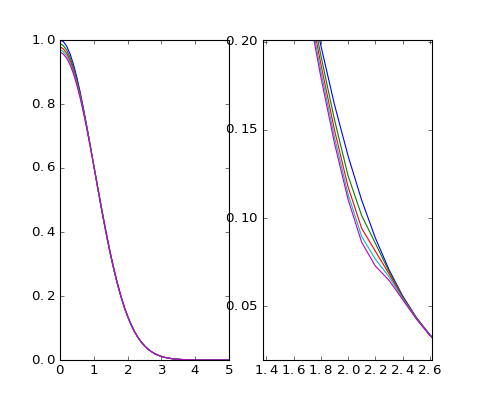

t=0.00: N=1.00, Jx=1.00, Jy=1.00
t=0.00: N=1.00, Jx=1.00, Jy=1.00
t=0.00: N=1.00, Jx=1.00, Jy=1.00
t=0.00: N=1.00, Jx=1.01, Jy=1.01
t=0.00: N=1.00, Jx=1.01, Jy=1.01
[ 0.     0.005  0.02   0.045  0.08   0.125  0.18   0.245  0.32   0.405
  0.5    0.605  0.72   0.845  0.98   1.125  1.28   1.445  1.62   1.805
  2.     2.205  2.42   2.645  2.88   3.125  3.38   3.645  3.92   4.205
  4.5    4.805  5.12   5.445  5.78   6.125  6.48   6.845  7.22   7.605
  8.     8.405  8.82   9.245  9.68  10.125 10.58  11.045 11.52  12.005
 12.5  ]


In [543]:
psis=psis2D
print(simp(x,x*np.average(psis[0,:].reshape((Ny,Nx)),axis=0,weights=y)))
print(simp(x,x*np.average(psis[-1,:].reshape((Ny,Nx)),axis=0,weights=y)))
print(xx.shape,yy.shape,psis[0,:].shape)
fig,axs=plt.subplots(1,2)

for i,t in enumerate(ts):
    norm = trapezoidal2D(x,y,X*Y*(psis[i,:].T).reshape((Ny,Nx)))
    Jx   = trapezoidal2D(x,y,0.5*X**2*X*Y*(psis[i,:].T).reshape((Ny,Nx)))
    Jy   = trapezoidal2D(x,y,0.5*Y**2*X*Y*(psis[i,:].T).reshape((Ny,Nx)))
    print('t=%2.2f: N=%.2f, Jx=%.2f, Jy=%.2f'%(t/3600,norm,Jx,Jy))
    
    xproj=trapezoidal2Dproj(x,y,psis[i,:].reshape((Ny,Nx)))
    axs[0].plot(x,xproj)#psis[i,0*Nx:1*Nx])
    yproj=trapezoidal2Dproj(y,x,psis[i,:].reshape((Ny,Nx)).T)
    axs[1].plot(x,psis[i,:Nx]) #.reshape(Ny,Nx),axis=1)
#     axs[1].plot(y,yproj)
print(.5*x**2)


<IPython.core.display.Javascript object>


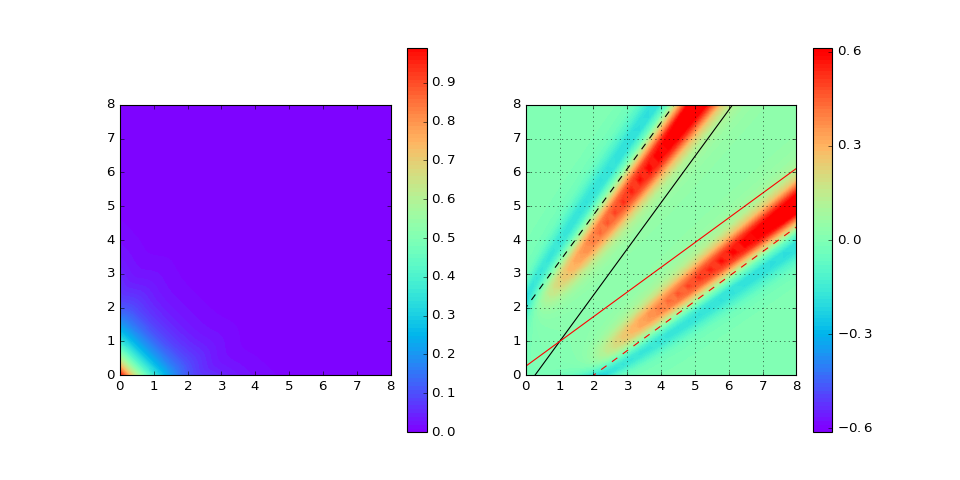

/home/sfuruset/miniconda3/lib/python3.5/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/sfuruset/miniconda3/lib/python3.5/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/sfuruset/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


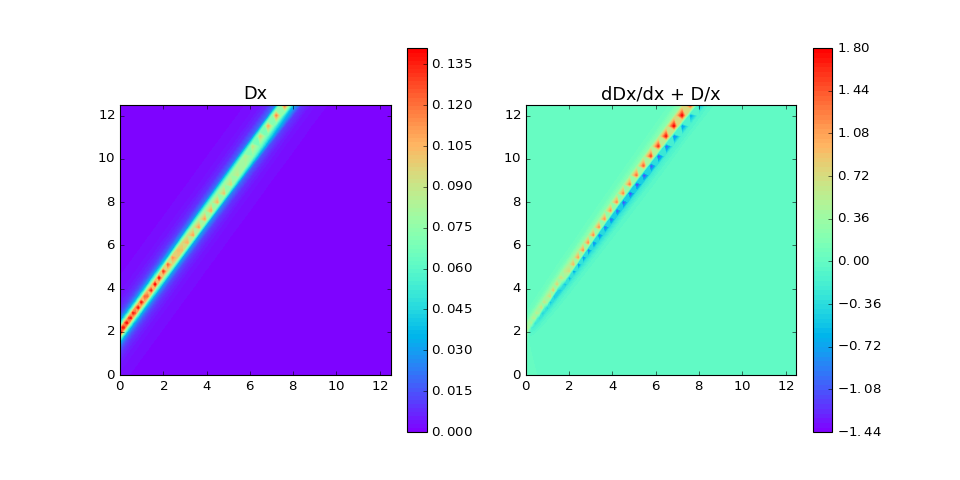

<IPython.core.display.Javascript object>


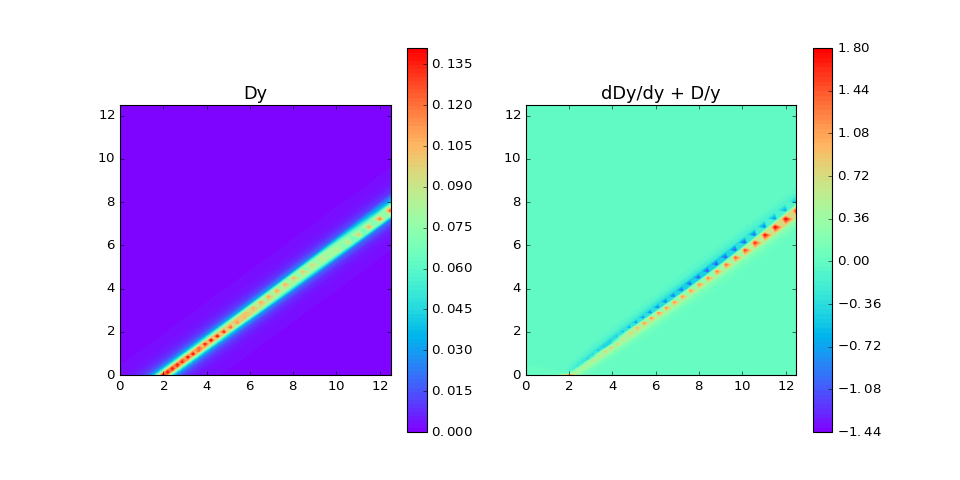

In [544]:
# Distribution

it = 4

fig=plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,psis[it,:].reshape((Ny,Nx)),100,vmin=0,vmax=1)
plt.colorbar()
jmax=8
ax1.axis([0,jmax,0,jmax])

ax2= fig.add_subplot(122,aspect='equal')
# plt.contourf(.5*X**2,.5*Y**2,(psis[-1,:]-0*psis[0,:]).reshape((Nx,Ny)),100)
# plt.contourf(.5*X**2,.5*Y**2,((psis[-1,:]-psis[0,:])/psis[0,:]).reshape((Nx,Ny)),np.linspace(-0.1,.1,100))
change = ((psis[it,:]-psis[0,:])/psis[0,:])
maxchange = min(1,np.max(np.abs(change))/3) *3
maxchange = .6
levels = np.concatenate(([-1e9],np.linspace(-maxchange,maxchange,100),[1e9]))
cs=plt.contourf(.5*X**2,.5*Y**2,change.reshape((Ny,Nx)),levels,cmap=['seismic','jet','rainbow'][2])
cs.set_clim(-maxchange,maxchange)
ax2.axis([0,jmax,0,jmax])
ax2.grid(True)
cb=plt.colorbar(ticks=np.linspace(-maxchange,maxchange,5))
# cb.ticks()


for i in range(2):
    main = np.array([0,jmax])
    if [ax,ay][i]==0: continue
    
    if i==0:
        plt.plot(-1/ax*(bx*main-(ax*Jxavg+bx*Jyavg)),main,'k')
        plt.plot(-1/ax*(bx*main-QxIns),main,'k--')
    else:
        plt.plot(main,-1/ay*(by*main-(ay*Jyavg+by*Jxavg)),'r') #0 for y diff
        plt.plot(main,-1/ay*(by*main-QyIns),'r--')

# Coefficiencts in x diffusion
fig=plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,preDer2x.reshape((Ny,Nx)),100)
plt.title('Dx')
# plt.plot(x,preDer2x[:Nx])
plt.colorbar()

ax2 = fig.add_subplot(122,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,preDer1x.reshape((Ny,Nx)),100)
plt.title('dDx/dx + D/x')
plt.colorbar()

# Coefficiencts in y diffusion
fig=plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,preDer2y.reshape((Ny,Nx)),100)
plt.title('Dy')
# plt.plot(x,preDer2x[:Nx])
plt.colorbar()

ax2 = fig.add_subplot(122,aspect='equal')
plt.contourf(.5*X**2,.5*Y**2,preDer1y.reshape((Ny,Nx)),100)
plt.title('dDy/dy + D/y')
plt.colorbar()




In [309]:
# print(xx.reshape((Nx,Ny)),yy.T)
# print(preDer1x.T*1e6)
# print(preDer2x.T*1e9)
# print(psi0.T[0])
# print(der1x)
# print(der1y)
# print(der2x)
# print(der2y)

<IPython.core.display.Javascript object>


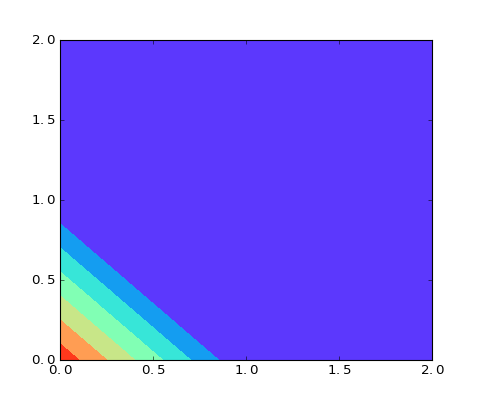

In [277]:
X,Y = np.meshgrid(x,y)
psi0 = np.exp(-0.5*X**2-0.5*Y**2)
plt.figure()
plt.contourf(psi0)

In [ ]:
# Interpolation

# Make a simple 2D interpolation
# obs: here it is FDM - only boundary values.

In [199]:
print(N2)

121


# Extra

<IPython.core.display.Javascript object>


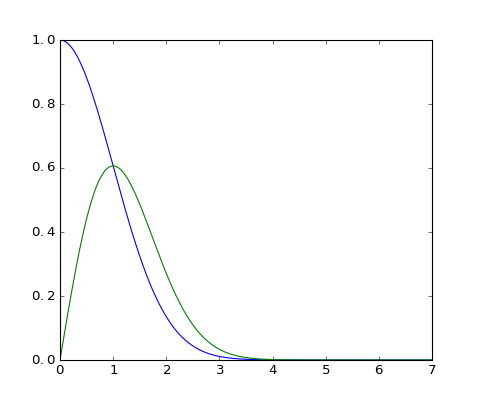

<IPython.core.display.Javascript object>


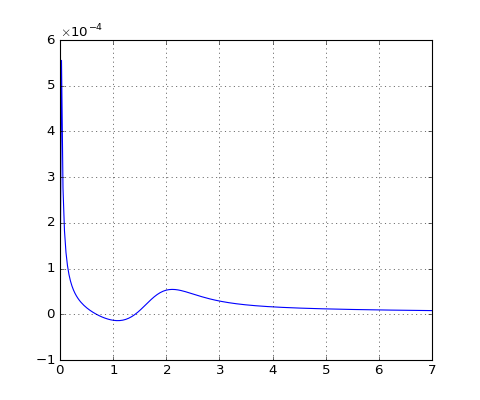

<IPython.core.display.Javascript object>


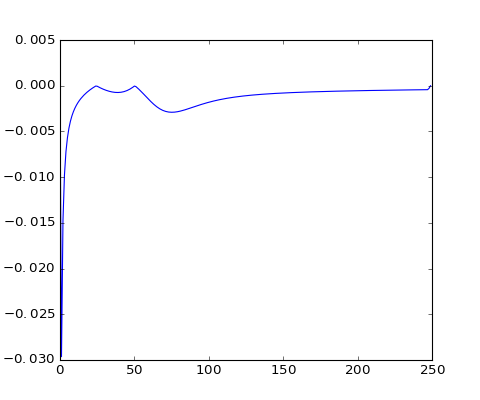

[1 2 3]
3


In [82]:
plt.figure()
plt.plot(r,psi)
plt.plot(r,r*psi)
plt.figure()
plt.plot(r,preDer1)
plt.grid(True)
plt.figure()
plt.plot(A1.diagonal())
# plt.plot(flux2.diagonal())
print(x)
print(x[-1])

In [782]:
Nr=5
Fm = np.eye(Nr,k=0)-np.eye(Nr,k=-1)
r= np.linspace(0,2,Nr)
redge = r[:-1]+np.diff(r)*0.5
Jxavg=1
preDer1Edge = derDD(redge,Dnr,Deq,Jxavg) + DD(redge,Dnr,Deq,Jxavg)/redge

print(Fm[1:]*preDer1Edge[:,np.newaxis])
print(u)
print(r,redge)
print(preDer1Edge)

[[-0.962  0.962  0.     0.     0.   ]
 [-0.     0.067 -0.067 -0.    -0.   ]
 [-0.    -0.     0.189 -0.189 -0.   ]
 [ 0.     0.     0.    -0.64   0.64 ]]
[ 2.    2.25  2.5   2.75  3.  ]
[ 0.   0.5  1.   1.5  2. ] [ 0.25  0.75  1.25  1.75]
[ 0.962 -0.067 -0.189  0.64 ]


In [99]:
if 0:
    # der1 = np.eye(Nr,k=0)-np.eye(Nr,k=-1)
    ve = np.arange(-2,2)
    ve = np.ones(Nr-1) #np.linspace(-2,2,Nr-1)
    v= np.concatenate(([0],ve,[0]))

    vp = v>0
    vn = v<0
    vvp=(v*vp)[np.newaxis,1:]
    vvm=(v*vn)[np.newaxis,:-1]
    upwind = np.eye(Nr) - np.eye(Nr,k=-1)
    dnwind = np.eye(Nr) - np.eye(Nr,k=1)
    flux2 = -(upwind)*(vvp) \
            +(dnwind)*(vvm)

    flux=  np.diag((v*vp)[1:-1],k=-1) - np.diag((v*vp)[1:],k=0) \
     - np.diag((v*vn)[1:-1],k= 1) + np.diag((v*vn)[:-1],k=0) 


    print(v)
    print(upwind)
    print(dnwind)
    print(flux)
    print(flux2)

In [208]:
n1=27
n2=33
print(r[n1])
print(der1[n1:n2,n1:n2])
print(dnwind[n1:n2,n1:n2])
print(upwind[n1:n2,n1:n2])
print(A1[n1:n2,n1:n2]*1e7)
print(preDer1Edge[n1:n2]*1e9)

1.26845637584
[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  

In [792]:
aa = np.ones((3,3))
bb = np.arange(3)
print(aa*bb[:,np.newaxis])
print(aa*bb[np.newaxis,:])

[[ 0.  0.  0.]
 [ 1.  1.  1.]
 [ 2.  2.  2.]]
[[ 0.  1.  2.]
 [ 0.  1.  2.]
 [ 0.  1.  2.]]


<IPython.core.display.Javascript object>


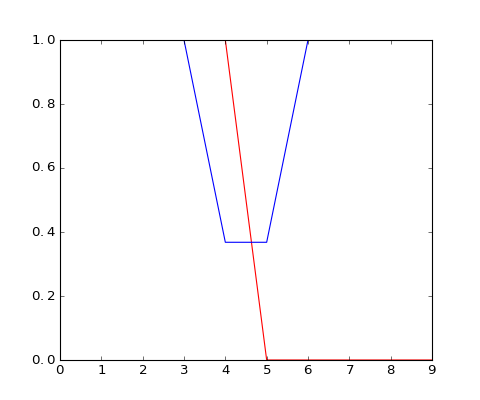

In [946]:


x = np.linspace(-4,4,15)
x = np.exp(-x**2)
x = np.ones(10)
x[5:] =0
plt.figure()
plt.plot(x,'r')
plt.plot(limiter(x))

In [227]:
a = np.arange(3)[:,np.newaxis]
# a = np.arange(3)
b = np.ones((3,3))
print(a.T)
print(b*a)

[[0 1 2]]
[[ 0.  0.  0.]
 [ 1.  1.  1.]
 [ 2.  2.  2.]]


# How to use odeint

In [277]:
Nr = 100
u = 1
def dydx(y,t,x):
    dx = np.diff(x)[0]
    A = (np.eye(Nr,k=1)+np.eye(Nr,k=-1)-2*np.eye(Nr))/dx**2
    return A.dot(y)

def dydx2(y,t,x):
    dx = np.diff(x)[0]
    A = -u*(np.eye(Nr,k=0)-np.eye(Nr,k=-1))/dx
    A[0,-1]=-A[0,0]
    
    return A.dot(y)

x = np.linspace(0,10,Nr)
y0 = np.exp(-(x-5)**2)

dt = 1*np.diff(x)[0]
t = np.arange(20)*dt

out = np.zeros((np.size(t),np.size(y0)))
for i,it in enumerate(t):
    if i==0: 
        out[i]=y0
    else:
        out[i] = out[i-1]+dt*dydx2(out[i-1],it,x)
    
# out=sc.integrate.odeint(dydx2,y0,t,args=(x,))

<IPython.core.display.Javascript object>


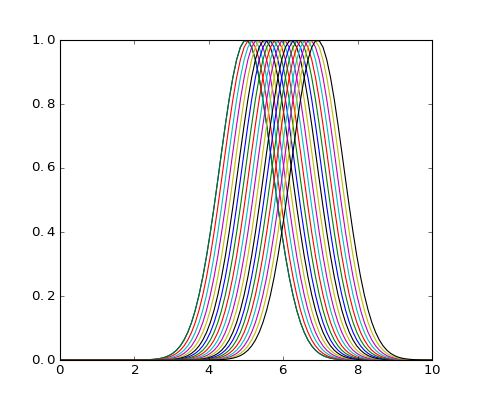

In [278]:
plt.figure()
plt.plot(x,y0)
plt.plot(x,out.T)

In [159]:
A= np.ones((4,4))*np.arange(4)
b = np.arange(4)

In [162]:
print(A*b)
print(A.dot(b))

[[ 0.  1.  4.  9.]
 [ 0.  1.  4.  9.]
 [ 0.  1.  4.  9.]
 [ 0.  1.  4.  9.]]
[ 14.  14.  14.  14.]


# Test integration

22.0 22.0 21.3333333333


<IPython.core.display.Javascript object>


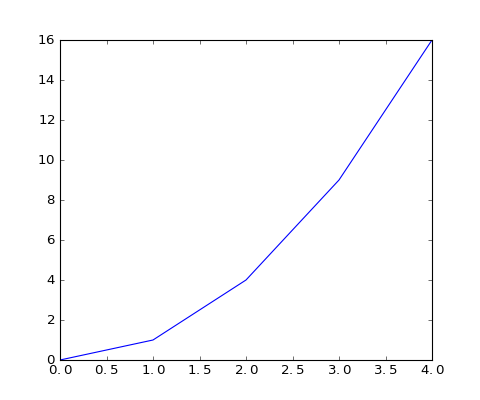

In [162]:
x = np.array([0,1,2,3,4])
y = np.array([0,1,4,9,16])


print(np.trapz(y,x),trapezoidal(x,y),simp(x,y))
plt.figure()
plt.plot(x,y)